In [ ]:
!pip -q install datasets scikit-learn tqdm


In [ ]:
import re, math, numpy as np, pandas as pd, torch
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold


In [ ]:
MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype="auto")
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("device:", device, "dtype:", next(model.parameters()).dtype)


device: cuda dtype: torch.bfloat16


## dataset sampling

In [ ]:
SEED = 0
N = 1000  # increase to 2000/5000 once it works

ds = load_dataset("squad_v2", split="validation")  # validation is smaller + stable
ds = ds.shuffle(seed=SEED).select(range(N))

def is_answerable(ex):
    return len(ex["answers"]["text"]) > 0

data = []
for ex in ds:
    data.append({
        "id": ex["id"],
        "context": ex["context"],
        "question": ex["question"],
        "is_answerable": is_answerable(ex),
    })
df = pd.DataFrame(data)
df.head()


README.md: 0.00B [00:00, ?B/s]

squad_v2/train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

squad_v2/validation-00000-of-00001.parqu(…):   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

,id,context,question,is_answerable
0,5ad24e50d7d075001a428c3d,John Schmitt and Ben Zipperer (2006) of the CE...,How much support is there for the UN approach ...,False
1,5729a26d6aef05140015505d,"In particular, this norm gets smaller when a n...",What principle highlights the significance of ...,True
2,5725d52f89a1e219009abf79,Packet switching contrasts with another princi...,What is circuit switching characterized by,True
3,57283db6ff5b5019007d9fc0,University of Chicago scholars have played a m...,In what year will the Barack Obama Presidentia...,True
4,57097141200fba1400367ff9,Virgin Media (re-branded in 2007 from NTL:Tele...,When was virgin media rebranded from NTL Telew...,True


In [ ]:
df_ok = df.copy()
y = df_ok["is_answerable"].astype(int).values  # 1=answerable, 0=unanswerable

# balance for probe
idx0 = np.where(y == 0)[0]
idx1 = np.where(y == 1)[0]
m = min(len(idx0), len(idx1))
rng = np.random.default_rng(SEED)
idx_bal = np.concatenate([rng.choice(idx0, m, replace=False), rng.choice(idx1, m, replace=False)])
df_bal = df_ok.iloc[idx_bal].reset_index(drop=True)
y = df_bal["is_answerable"].astype(int).values


# evaluate


In [ ]:
def make_prompt(context, question):
    return (
        "Decide if the question is answerable using ONLY the provided context.\n\n"
        f"Context:\n{context}\n\n"
        f"Question:\n{question}\n\n"
        "Choose exactly one:\n"
        "(A) UNANSWERABLE — the context does not contain enough info\n"
        "(B) ANSWERABLE — the context contains enough info\n\n"
        "FINAL: ("
    )


@torch.no_grad()
def choose_A_or_B(prompt):
    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)
    out = model.generate(
        **enc,
        do_sample=False,     # greedy
        max_new_tokens=1,    # just pick A or B
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    gen_ids = out[0][enc["input_ids"].shape[1]:]
    gen = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()

    if gen.startswith("A"):
        return 0  # unanswerable
    if gen.startswith("B"):
        return 1  # answerable
    return None

prompts = [make_prompt(c,q) for c,q in zip(df["context"], df["question"])]

labels = []
for p in tqdm(prompts[:100], desc="A/B sanity check"):
    labels.append(choose_A_or_B(p))

print(pd.Series(labels).value_counts(dropna=False))
print("parse fail rate:", pd.Series(labels).isna().mean())



A/B sanity check:   0%|          | 0/100 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


1    99
0     1
Name: count, dtype: int64
parse fail rate: 0.0


In [ ]:
labels_full = []
for p in tqdm(prompts, desc="Label all prompts"):
    labels_full.append(choose_A_or_B(p))

df2 = df.copy()
df2["abstain"] = labels_full  # now lengths match


Label all prompts:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
df2 = df.copy()
df2["abstain"] = labels_full  # after you run for N examples
df_ok = df2.dropna(subset=["abstain"]).copy()
y = df_ok["abstain"].astype(int).values
print("counts:", (y==0).sum(), (y==1).sum())

counts: 8 992


In [ ]:
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

@torch.no_grad()
def score_A_vs_B(prompt):
    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)
    out = model(**enc, use_cache=False)
    logits = out.logits[0, -1, :]
    logp = F.log_softmax(logits, dim=-1)

    # candidate token ids (handle possible leading space)
    idA = tokenizer.encode("A", add_special_tokens=False)[0]
    idA_sp = tokenizer.encode(" A", add_special_tokens=False)[0]
    idB = tokenizer.encode("B", add_special_tokens=False)[0]
    idB_sp = tokenizer.encode(" B", add_special_tokens=False)[0]

    logpA = torch.logsumexp(torch.stack([logp[idA], logp[idA_sp]]), dim=0)
    logpB = torch.logsumexp(torch.stack([logp[idB], logp[idB_sp]]), dim=0)
    return (logpB - logpA).item()  # >0 => prefers B

scores = []
for p in tqdm(prompts[:200], desc="A/B logprob"):
    scores.append(score_A_vs_B(p))

labels200 = [1 if s > 0 else 0 for s in scores]
print(pd.Series(labels200).value_counts())
print("score stats:", np.min(scores), np.median(scores), np.max(scores))


A/B logprob:   0%|          | 0/200 [00:00<?, ?it/s]

1    198
0      2
Name: count, dtype: int64
score stats: -3.0 8.75 11.75


In [ ]:
def make_prompt(context, question):
    return (
        "Decide if the question is answerable using ONLY the provided context.\n"
        "If the context is insufficient, you MUST choose UNANSWERABLE.\n\n"
        f"Context:\n{context}\n\n"
        f"Question:\n{question}\n\n"
        "Output exactly one token from this set:\n"
        "ANSWERABLE\n"
        "UNANSWERABLE\n\n"
        "FINAL: "
    )

import torch.nn.functional as F

@torch.no_grad()
def logprob_completion(prompt, completion, max_length=1024):
    # full = prompt + completion; compute sum log p(token_t | previous)
    full = prompt + completion
    enc_full = tokenizer(full, return_tensors="pt", truncation=True, max_length=max_length).to(device)
    enc_prompt = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_length).to(device)

    input_ids = enc_full["input_ids"]
    prompt_len = enc_prompt["input_ids"].shape[1]

    out = model(**enc_full, use_cache=False)
    logp = F.log_softmax(out.logits, dim=-1)  # [1, seq, vocab]

    # tokens corresponding to completion span are input_ids[prompt_len: ]
    # their logprobs are at positions [prompt_len-1 ... end-2] predicting next token
    comp_ids = input_ids[0, prompt_len:]  # tokens of completion
    pred_pos = torch.arange(prompt_len-1, prompt_len-1 + comp_ids.shape[0], device=device)
    token_logps = logp[0, pred_pos, comp_ids]
    return float(token_logps.sum().detach().cpu())

@torch.no_grad()
def score_answerable_vs_unanswerable(prompt):
    lp_ans = logprob_completion(prompt, "ANSWERABLE")
    lp_un  = logprob_completion(prompt, "UNANSWERABLE")
    return lp_ans - lp_un  # >0 => prefers ANSWERABLE

scores = []
for p in tqdm(prompts[:200], desc="score strings"):
    scores.append(score_answerable_vs_unanswerable(p))

labels200 = [1 if s > 0 else 0 for s in scores]  # 1=ANSWERABLE
print(pd.Series(labels200).value_counts())
print("score stats:", np.min(scores), np.median(scores), np.max(scores))


NameError: name 'prompts' is not defined

In [ ]:
SEED = 0
N = 1000  # total examples (500 pos, 500 neg)
rng = np.random.default_rng(SEED)

ds = load_dataset("squad_v2", split="validation")
ds_ans = [ex for ex in ds if len(ex["answers"]["text"]) > 0]

# sample N/2 answerable base examples
base = rng.choice(len(ds_ans), size=N//2, replace=False)
base_ex = [ds_ans[i] for i in base]

# build positives (correct context)
pos = [{"context": ex["context"], "question": ex["question"], "y_true": 1} for ex in base_ex]

# build negatives (swap context)
all_contexts = [ex["context"] for ex in ds_ans]
neg = []
for ex in base_ex:
    # choose a different random context
    ctx = all_contexts[rng.integers(len(all_contexts))]
    while ctx == ex["context"]:
        ctx = all_contexts[rng.integers(len(all_contexts))]
    neg.append({"context": ctx, "question": ex["question"], "y_true": 0})

df_balanced = pd.DataFrame(pos + neg).sample(frac=1, random_state=SEED).reset_index(drop=True)
print(df_balanced["y_true"].value_counts())


y_true
0    500
1    500
Name: count, dtype: int64


In [ ]:
prompts = [make_prompt(c,q) for c,q in zip(df_balanced["context"], df_balanced["question"])]

scores = []
for p in tqdm(prompts[:200], desc="score strings sanity"):
    scores.append(score_answerable_vs_unanswerable(p))

pred200 = np.array([1 if s > 0 else 0 for s in scores])
print("pred counts:", pd.Series(pred200).value_counts())
print("sanity acc (200):", (pred200 == df_balanced["y_true"].values[:200]).mean())


score strings sanity:   0%|          | 0/200 [00:00<?, ?it/s]

pred counts: 0    167
1     33
Name: count, dtype: int64
sanity acc (200): 0.445


In [ ]:
# Recompute pred directly from the scores you just computed
scores_arr = np.array(scores)
pred_from_scores = (scores_arr > 0).astype(int)

print("pred_from_scores counts:", pd.Series(pred_from_scores).value_counts())
print("median score:", np.median(scores_arr))

# Show a few rows
for i in range(10):
    print(i, "score=", float(scores_arr[i]),
          "pred=", int(pred_from_scores[i]),
          "y_true=", int(df_balanced["y_true"].values[i]))


pred_from_scores counts: 0    167
1     33
Name: count, dtype: int64
median score: -8.678436279296875e-05
0 score= -2.193450927734375e-05 pred= 0 y_true= 0
1 score= 6.29425048828125e-05 pred= 1 y_true= 0
2 score= -0.0001926422119140625 pred= 0 y_true= 1
3 score= -0.0001277923583984375 pred= 0 y_true= 0
4 score= -6.103515625e-05 pred= 0 y_true= 0
5 score= 1.9073486328125e-05 pred= 1 y_true= 0
6 score= -0.00040149688720703125 pred= 0 y_true= 1
7 score= 1.52587890625e-05 pred= 1 y_true= 1
8 score= -0.00016307830810546875 pred= 0 y_true= 1
9 score= 4.291534423828125e-05 pred= 1 y_true= 0


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

# Recommended for QA: keep the end (question + FINAL) if you must truncate
tokenizer.truncation_side = "left"

def build_input_ids_with_reserve(prompt: str, completion: str, max_length: int):
    # Tokenize without truncation so we control truncation ourselves
    prompt_ids = tokenizer.encode(prompt, add_special_tokens=False)
    comp_ids   = tokenizer.encode(completion, add_special_tokens=False)

    # Ensure the combined length fits by truncating prompt_ids from the LEFT
    total = len(prompt_ids) + len(comp_ids)
    if total > max_length:
        overflow = total - max_length
        prompt_ids = prompt_ids[overflow:]  # drop earliest tokens

    input_ids = torch.tensor([prompt_ids + comp_ids], device=device)
    return input_ids, len(prompt_ids), len(comp_ids)

@torch.no_grad()
def logprob_completion_safe(prompt: str, completion: str, max_length: int):
    input_ids, prompt_len, comp_len = build_input_ids_with_reserve(prompt, completion, max_length=max_length)

    out = model(input_ids=input_ids, use_cache=False)
    logp = F.log_softmax(out.logits, dim=-1)  # [1, seq, vocab]

    # completion tokens are at positions [prompt_len, ..., prompt_len+comp_len-1] in input_ids
    comp_ids = input_ids[0, prompt_len:prompt_len+comp_len]  # [comp_len]

    # their predicted logits are at positions one step before each token
    pred_pos = torch.arange(prompt_len - 1, prompt_len - 1 + comp_len, device=device)

    token_logps = logp[0, pred_pos, comp_ids]
    return float(token_logps.sum().detach().cpu())

@torch.no_grad()
def score_answerable_vs_unanswerable_safe(prompt: str, max_length: int):
    # include leading-space variants because generation usually begins with a space
    ans_vars = ["ANSWERABLE", " ANSWERABLE", "\nANSWERABLE"]
    un_vars  = ["UNANSWERABLE", " UNANSWERABLE", "\nUNANSWERABLE"]

    lp_ans = np.logaddexp.reduce([logprob_completion_safe(prompt, v, max_length) for v in ans_vars])
    lp_un  = np.logaddexp.reduce([logprob_completion_safe(prompt, v, max_length) for v in un_vars])

    return lp_ans - lp_un  # >0 => prefers ANSWERABLE


In [ ]:
MAXLEN = getattr(model.config, "max_position_embeddings", 2048)

prompts = [make_prompt(c,q) for c,q in zip(df_balanced["context"], df_balanced["question"])]

scores = []
for p in tqdm(prompts[:200], desc="score safe strings"):
    scores.append(score_answerable_vs_unanswerable_safe(p, MAXLEN))

scores_arr = np.array(scores)
pred200 = (scores_arr > 0).astype(int)

print("pred counts:", pd.Series(pred200).value_counts())
print("sanity acc (200):", (pred200 == df_balanced["y_true"].values[:200]).mean())
print("score stats:", np.min(scores_arr), np.median(scores_arr), np.max(scores_arr))


score safe strings:   0%|          | 0/200 [00:00<?, ?it/s]

pred counts: 1    118
0     82
Name: count, dtype: int64
sanity acc (200): 0.87
score stats: -8.59563573966522 1.0338669632265314 7.897478302544636


# layer wise probe tests

In [ ]:
SEED = 0
rng = np.random.default_rng(SEED)

# Use your df_balanced (1000 rows, y_true 500/500)
idx0 = np.where(df_balanced["y_true"].values == 0)[0]
idx1 = np.where(df_balanced["y_true"].values == 1)[0]
m = 150

sel = np.concatenate([rng.choice(idx0, m, replace=False),
                      rng.choice(idx1, m, replace=False)])
df_pilot = df_balanced.iloc[sel].sample(frac=1, random_state=SEED).reset_index(drop=True)

y_true = df_pilot["y_true"].astype(int).values


In [ ]:
MAXLEN = getattr(model.config, "max_position_embeddings", 2048)

prompts = [make_prompt(c,q) for c,q in zip(df_pilot["context"], df_pilot["question"])]

scores = []
for p in tqdm(prompts, desc="score decision"):
    scores.append(score_answerable_vs_unanswerable_safe(p, MAXLEN))

scores = np.array(scores)
y_pred = (scores > 0).astype(int)

print("pilot y_true counts:", pd.Series(y_true).value_counts())
print("pilot y_pred counts:", pd.Series(y_pred).value_counts())
print("pilot acc:", (y_pred == y_true).mean())


score decision:   0%|          | 0/300 [00:00<?, ?it/s]

pilot y_true counts: 1    150
0    150
Name: count, dtype: int64
pilot y_pred counts: 1    184
0    116
Name: count, dtype: int64
pilot acc: 0.82


In [ ]:
# MAXLEN = getattr(model.config, "max_position_embeddings", 2048)

# prompts = [make_prompt(c,q) for c,q in zip(df_pilot["context"], df_pilot["question"])]

# scores = []
# for p in tqdm(prompts, desc="score decision"):
#     scores.append(score_answerable_vs_unanswerable_safe(p, MAXLEN))

# scores = np.array(scores)
# y_pred = (scores > 0).astype(int)

# print("pilot y_true counts:", pd.Series(y_true).value_counts())
# print("pilot y_pred counts:", pd.Series(y_pred).value_counts())
# print("pilot acc:", (y_pred == y_true).mean())


score decision:   0%|          | 0/300 [00:00<?, ?it/s]

pilot y_true counts: 1    150
0    150
Name: count, dtype: int64
pilot y_pred counts: 1    184
0    116
Name: count, dtype: int64
pilot acc: 0.82


In [ ]:
@torch.no_grad()
def hidden_states_at_decision(prompt, max_length=2048):
    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_length).to(device)
    out = model(**enc, output_hidden_states=True, use_cache=False)
    hs = [h[0, -1, :].float().cpu().numpy() for h in out.hidden_states]  # includes embedding layer
    return np.stack(hs)  # [L, d_model]

X_layers = []
for p in tqdm(prompts, desc="extract hiddens"):
    X_layers.append(hidden_states_at_decision(p, MAXLEN))

X_layers = np.stack(X_layers)  # [N, L, d_model]
print("X_layers:", X_layers.shape)


extract hiddens:   0%|          | 0/300 [00:00<?, ?it/s]

X_layers: (300, 29, 1536)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

def layerwise_probe_acc(X_layers, y, n_splits=5, seed=0):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    L = X_layers.shape[1]
    acc = np.zeros(L)

    for l in range(L):
        X = X_layers[:, l, :]
        fold = []
        for tr, te in skf.split(X, y):
            clf = LogisticRegression(max_iter=2000)
            clf.fit(X[tr], y[tr])
            fold.append(clf.score(X[te], y[te]))
        acc[l] = np.mean(fold)
    return acc

# acc_true = layerwise_probe_acc(X_layers, y_true, seed=SEED)
# acc_pred = layerwise_probe_acc(X_layers, y_pred, seed=SEED)


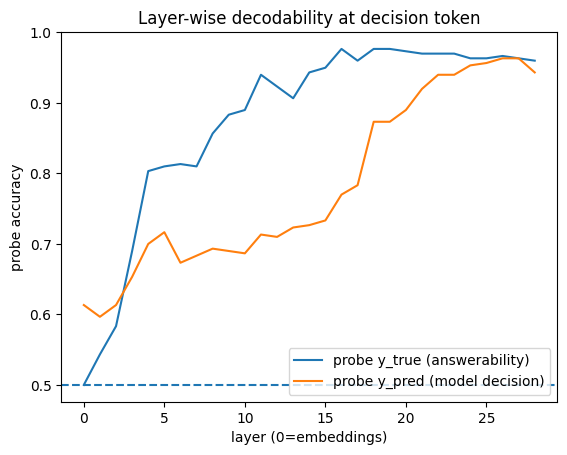

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(acc_true, label="probe y_true (answerability)")
plt.plot(acc_pred, label="probe y_pred (model decision)")
plt.axhline(0.5, linestyle="--")
plt.xlabel("layer (0=embeddings)")
plt.ylabel("probe accuracy")
plt.title("Layer-wise decodability at decision token")
plt.legend()
plt.show()


X_layers shape: (300, 29, 1536)
y_true shape: (300,)
y_pred shape: (300,)


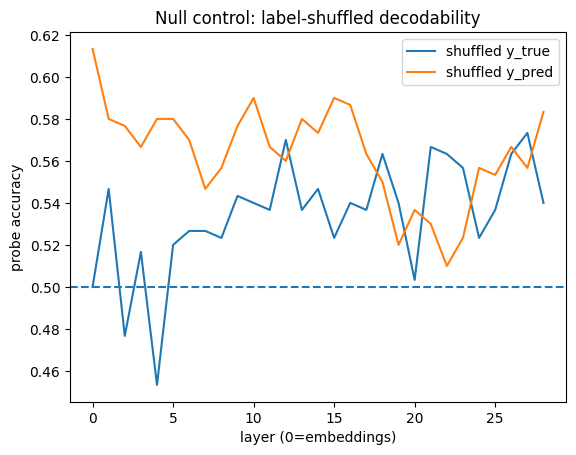

Mean shuffled accuracy (y_true): 0.5342528735632185
Mean shuffled accuracy (y_pred): 0.5635632183908046
Max shuffled accuracy (y_true): 0.5733333333333334
Max shuffled accuracy (y_pred): 0.6133333333333334


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- sanity checks: make sure shapes match ---
print("X_layers shape:", X_layers.shape)  # [N, L, d]
print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

assert X_layers.shape[0] == len(y_true) == len(y_pred), "Mismatch: N in X_layers vs labels"

# --- shuffle labels (null control) ---
SEED = 123
rng = np.random.default_rng(SEED)

y_true_shuf = rng.permutation(y_true)  # preserves class balance
y_pred_shuf = rng.permutation(y_pred)

# --- run probes on shuffled labels ---
acc_true_shuf = layerwise_probe_acc(X_layers, y_true_shuf, seed=SEED)
acc_pred_shuf = layerwise_probe_acc(X_layers, y_pred_shuf, seed=SEED)

# --- plot ---
plt.figure()
plt.plot(acc_true_shuf, label="shuffled y_true")
plt.plot(acc_pred_shuf, label="shuffled y_pred")
plt.axhline(0.5, linestyle="--")
plt.xlabel("layer (0=embeddings)")
plt.ylabel("probe accuracy")
plt.title("Null control: label-shuffled decodability")
plt.legend()
plt.show()

print("Mean shuffled accuracy (y_true):", float(np.mean(acc_true_shuf)))
print("Mean shuffled accuracy (y_pred):", float(np.mean(acc_pred_shuf)))
print("Max shuffled accuracy (y_true):", float(np.max(acc_true_shuf)))
print("Max shuffled accuracy (y_pred):", float(np.max(acc_pred_shuf)))


In [ ]:
print("y_true counts:", pd.Series(y_true).value_counts())
print("y_pred counts:", pd.Series(y_pred).value_counts())


y_true counts: 1    150
0    150
Name: count, dtype: int64
y_pred counts: 1    184
0    116
Name: count, dtype: int64


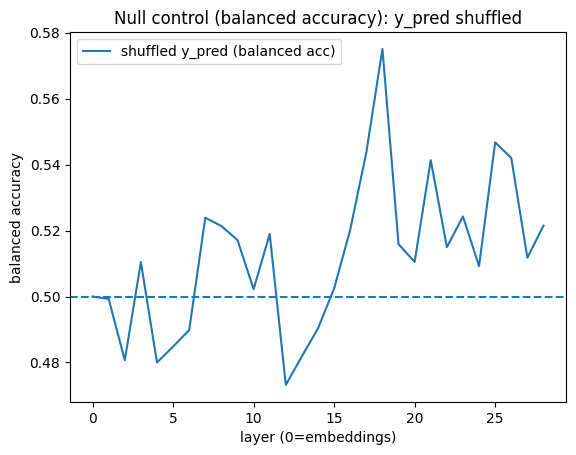

mean balacc: 0.5121970546258402 max: 0.5750881316098708


In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

def layerwise_probe_balacc(X_layers, y, n_splits=5, seed=0):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    L = X_layers.shape[1]
    balacc = np.zeros(L)

    for l in range(L):
        X = X_layers[:, l, :]
        scores = []
        for tr, te in skf.split(X, y):
            clf = LogisticRegression(max_iter=2000)
            clf.fit(X[tr], y[tr])
            pred = clf.predict(X[te])
            scores.append(balanced_accuracy_score(y[te], pred))
        balacc[l] = np.mean(scores)
    return balacc

SEED = 123
rng = np.random.default_rng(SEED)
y_pred_shuf = rng.permutation(y_pred)

balacc_pred_shuf = layerwise_probe_balacc(X_layers, y_pred_shuf, seed=SEED)

plt.figure()
plt.plot(balacc_pred_shuf, label="shuffled y_pred (balanced acc)")
plt.axhline(0.5, linestyle="--")
plt.xlabel("layer (0=embeddings)")
plt.ylabel("balanced accuracy")
plt.title("Null control (balanced accuracy): y_pred shuffled")
plt.legend()
plt.show()

print("mean balacc:", float(np.mean(balacc_pred_shuf)), "max:", float(np.max(balacc_pred_shuf)))


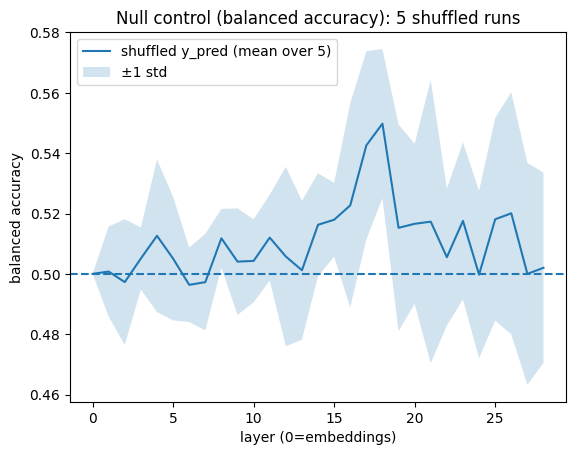

Null mean balacc across layers: 0.5108681019850435
Null max balacc across layers: 0.5497816294555425
Null max+std across layers: 0.5745426459441638


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

def layerwise_probe_balacc(X_layers, y, n_splits=5, seed=0):
    """
    Layer-wise balanced-accuracy probe using logistic regression + stratified CV.
    X_layers: [N, L, d]
    y: [N]
    returns: [L] balanced accuracy per layer
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    L = X_layers.shape[1]
    balacc = np.zeros(L, dtype=float)

    for l in range(L):
        X = X_layers[:, l, :]
        fold_scores = []
        for tr, te in skf.split(X, y):
            clf = LogisticRegression(max_iter=2000)
            clf.fit(X[tr], y[tr])
            pred = clf.predict(X[te])
            fold_scores.append(balanced_accuracy_score(y[te], pred))
        balacc[l] = float(np.mean(fold_scores))
    return balacc

# --------- 5-shuffle null experiment ----------
N_SHUFFLES = 5
BASE_SEED = 123

# Sanity check
assert X_layers.shape[0] == len(y_pred), "X_layers and y_pred must have same N"

curves = []
for k in range(N_SHUFFLES):
    seed = BASE_SEED + k
    rng = np.random.default_rng(seed)
    y_shuf = rng.permutation(y_pred)  # breaks relationship, keeps label counts
    balacc = layerwise_probe_balacc(X_layers, y_shuf, n_splits=5, seed=seed)
    curves.append(balacc)

curves = np.stack(curves)  # [K, L]
mean_curve = curves.mean(axis=0)
std_curve = curves.std(axis=0)

# --------- plot ----------
layers = np.arange(X_layers.shape[1])

plt.figure()
plt.plot(layers, mean_curve, label=f"shuffled y_pred (mean over {N_SHUFFLES})")
plt.fill_between(layers, mean_curve - std_curve, mean_curve + std_curve, alpha=0.2, label="±1 std")
plt.axhline(0.5, linestyle="--")
plt.xlabel("layer (0=embeddings)")
plt.ylabel("balanced accuracy")
plt.title("Null control (balanced accuracy): 5 shuffled runs")
plt.legend()
plt.show()

print("Null mean balacc across layers:", float(mean_curve.mean()))
print("Null max balacc across layers:", float(mean_curve.max()))
print("Null max+std across layers:", float((mean_curve + std_curve).max()))


# activation patching


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = model.device
MAXLEN = getattr(model.config, "max_position_embeddings", 2048)

# ---------- locate transformer blocks ----------
def get_transformer_blocks(model):
    if hasattr(model, "model") and hasattr(model.model, "layers"):
        return list(model.model.layers)
    if hasattr(model, "transformer") and hasattr(model.transformer, "h"):
        return list(model.transformer.h)
    if hasattr(model, "gpt_neox") and hasattr(model.gpt_neox, "layers"):
        return list(model.gpt_neox.layers)
    raise ValueError("Could not find transformer blocks; inspect model architecture.")

blocks = get_transformer_blocks(model)
n_blocks = len(blocks)
print("Found transformer blocks:", n_blocks)

# ---------- safe token construction (prompt truncated with reserve for completion) ----------
def build_ids(prompt: str, completion: str, max_length: int):
    prompt_ids = tokenizer.encode(prompt, add_special_tokens=False)
    comp_ids   = tokenizer.encode(completion, add_special_tokens=False)
    total = len(prompt_ids) + len(comp_ids)
    if total > max_length:
        overflow = total - max_length
        prompt_ids = prompt_ids[overflow:]  # left truncate prompt
    input_ids = torch.tensor([prompt_ids + comp_ids], device=device)
    prompt_len = len(prompt_ids)
    comp_len = len(comp_ids)
    return input_ids, prompt_len, comp_len

@torch.no_grad()
def logprob_completion(prompt: str, completion: str, hook=None, max_length: int = MAXLEN):
    input_ids, prompt_len, comp_len = build_ids(prompt, completion, max_length=max_length)

    if hook is None:
        out = model(input_ids=input_ids, use_cache=False)
    else:
        with hook:
            out = model(input_ids=input_ids, use_cache=False)

    logp = F.log_softmax(out.logits, dim=-1)
    comp_ids = input_ids[0, prompt_len:prompt_len+comp_len]
    pred_pos = torch.arange(prompt_len - 1, prompt_len - 1 + comp_len, device=device)
    return float(logp[0, pred_pos, comp_ids].sum().detach().cpu())

# ---------- SIMPLE decision score for patching (fixed variants, equal length regime) ----------
ANS = " ANSWERABLE"
UN  = " UNANSWERABLE"

@torch.no_grad()
def decision_score_simple(prompt: str, hook=None, max_length: int = MAXLEN):
    lp_ans = logprob_completion(prompt, ANS, hook=hook, max_length=max_length)
    lp_un  = logprob_completion(prompt, UN,  hook=hook, max_length=max_length)
    return float(lp_ans - lp_un)

# ---------- hook that patches one layer at one token index ----------
class PatchLayerToken:
    def __init__(self, block_module, token_index: int, donor_vec: torch.Tensor):
        self.block = block_module
        self.token_index = token_index
        self.donor_vec = donor_vec
        self.handle = None

    def __enter__(self):
        def hook_fn(module, inputs, output):
            out = output[0] if isinstance(output, tuple) else output  # [B,T,D]
            # guard: if seq shorter than token_index, do nothing (shouldn't happen now)
            if self.token_index >= out.shape[1]:
                return output

            out2 = out.clone()
            out2[0, self.token_index, :] = self.donor_vec
            if isinstance(output, tuple):
                return (out2,) + output[1:]
            return out2

        self.handle = self.block.register_forward_hook(hook_fn)
        return self

    def __exit__(self, exc_type, exc, tb):
        if self.handle is not None:
            self.handle.remove()
        return False

# ---------- capture donor vector at the *correct* decision token index for this (prompt,completion) regime ----------
@torch.no_grad()
def get_block_output_vec(prompt: str, layer_idx: int, completion_for_index: str = ANS, max_length: int = MAXLEN):
    input_ids, prompt_len, comp_len = build_ids(prompt, completion_for_index, max_length=max_length)
    decision_index = prompt_len - 1  # last token of (possibly truncated) prompt

    captured = {}
    def capture_hook(module, inputs, output):
        out = output[0] if isinstance(output, tuple) else output
        captured["vec"] = out[0, decision_index, :].detach()
        return output

    h = blocks[layer_idx].register_forward_hook(capture_hook)
    _ = model(input_ids=input_ids, use_cache=False)
    h.remove()

    return captured["vec"], decision_index

# ---------- build pairs ----------
def sample_pairs(df_balanced, n_pairs=10, seed=0):
    rng = np.random.default_rng(seed)
    idx_pos = np.where(df_balanced["y_true"].values == 1)[0]
    idx_neg = np.where(df_balanced["y_true"].values == 0)[0]
    pos_sel = rng.choice(idx_pos, size=n_pairs, replace=False)
    neg_sel = rng.choice(idx_neg, size=n_pairs, replace=False)
    return list(zip(pos_sel, neg_sel))

Found transformer blocks: 28


Found transformer blocks: 28


Activation patching (Δscore):   0%|          | 0/28 [00:00<?, ?it/s]

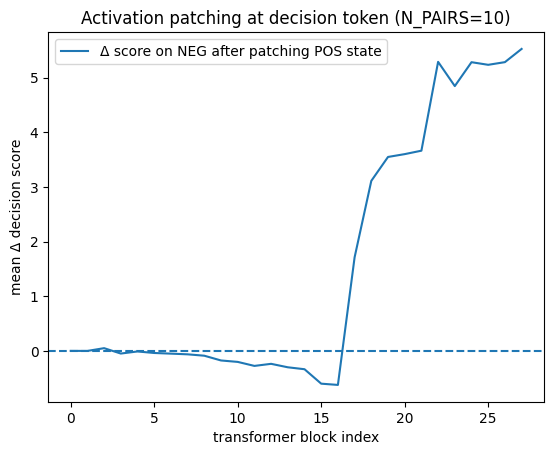

Top 5 layers by |Δ|: [27 22 26 24 25]


In [ ]:


N_PAIRS = 10  # start small; bump to 20 once it runs
pairs = sample_pairs(df_balanced, n_pairs=N_PAIRS, seed=0)

# ---------- patching sweep ----------
delta_by_layer = np.zeros(n_blocks, dtype=float)

for l in tqdm(range(n_blocks), desc="Activation patching (Δscore)"):
    deltas = []
    for pos_i, neg_i in pairs:
        p_pos = make_prompt(df_balanced.loc[pos_i, "context"], df_balanced.loc[pos_i, "question"])
        p_neg = make_prompt(df_balanced.loc[neg_i, "context"], df_balanced.loc[neg_i, "question"])

        donor_vec, _ = get_block_output_vec(p_pos, layer_idx=l, completion_for_index=ANS)

        # IMPORTANT: compute token_index for NEG under the SAME regime
        _, token_index_neg = get_block_output_vec(p_neg, layer_idx=l, completion_for_index=ANS)

        base = decision_score_simple(p_neg)
        hook = PatchLayerToken(blocks[l], token_index=token_index_neg, donor_vec=donor_vec)
        patched = decision_score_simple(p_neg, hook=hook)

        deltas.append(patched - base)

    delta_by_layer[l] = float(np.mean(deltas))

plt.figure()
plt.plot(delta_by_layer, label="Δ score on NEG after patching POS state")
plt.axhline(0.0, linestyle="--")
plt.xlabel("transformer block index")
plt.ylabel("mean Δ decision score")
plt.title(f"Activation patching at decision token (N_PAIRS={N_PAIRS})")
plt.legend()
plt.show()

print("Top 5 layers by |Δ|:", np.argsort(-np.abs(delta_by_layer))[:5])


Flip rate sweep:   0%|          | 0/28 [00:00<?, ?it/s]

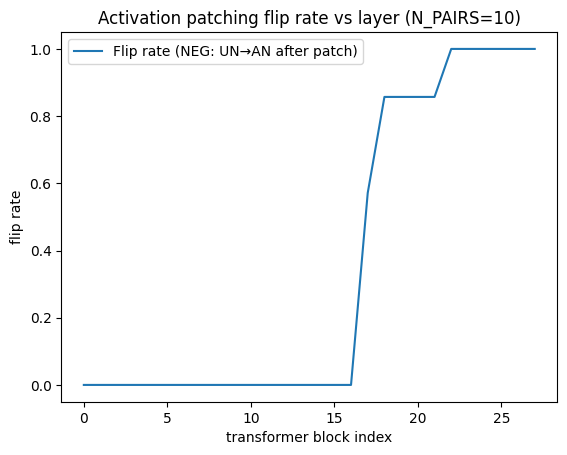

Max flip rate: 1.0 at layer 22


In [ ]:
# Compute flip rate: how often NEG flips from score<0 to score>0 after patching
flip_rate = np.zeros(n_blocks)

for l in tqdm(range(n_blocks), desc="Flip rate sweep"):
    flips = 0
    total = 0
    for pos_i, neg_i in pairs:
        p_pos = make_prompt(df_balanced.loc[pos_i, "context"], df_balanced.loc[pos_i, "question"])
        p_neg = make_prompt(df_balanced.loc[neg_i, "context"], df_balanced.loc[neg_i, "question"])

        donor_vec, _ = get_block_output_vec(p_pos, layer_idx=l, completion_for_index=ANS)
        _, token_index_neg = get_block_output_vec(p_neg, layer_idx=l, completion_for_index=ANS)

        base = decision_score_simple(p_neg)
        hook = PatchLayerToken(blocks[l], token_index=token_index_neg, donor_vec=donor_vec)
        patched = decision_score_simple(p_neg, hook=hook)

        # Count only cases where base is truly "UNANSWERABLE-leaning"
        if base < 0:
            total += 1
            if patched > 0:
                flips += 1

    flip_rate[l] = flips / max(total, 1)

plt.figure()
plt.plot(flip_rate, label="Flip rate (NEG: UN→AN after patch)")
plt.xlabel("transformer block index")
plt.ylabel("flip rate")
plt.title(f"Activation patching flip rate vs layer (N_PAIRS={N_PAIRS})")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()

print("Max flip rate:", float(np.max(flip_rate)), "at layer", int(np.argmax(flip_rate)))


Reverse flip rate sweep:   0%|          | 0/28 [00:00<?, ?it/s]

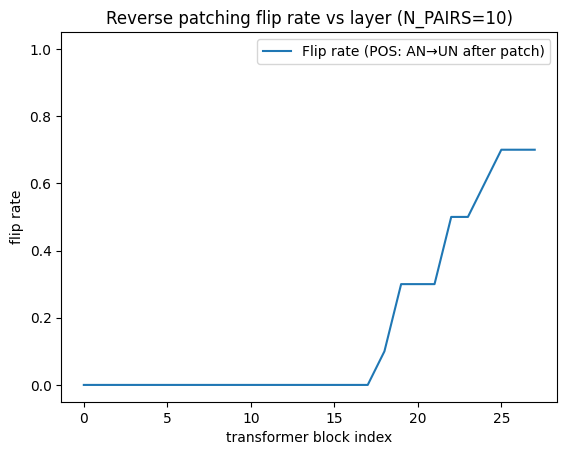

Max reverse flip rate: 0.7 at layer 25


In [ ]:
flip_rate_rev = np.zeros(n_blocks)

for l in tqdm(range(n_blocks), desc="Reverse flip rate sweep"):
    flips = 0
    total = 0
    for pos_i, neg_i in pairs:
        p_pos = make_prompt(df_balanced.loc[pos_i, "context"], df_balanced.loc[pos_i, "question"])
        p_neg = make_prompt(df_balanced.loc[neg_i, "context"], df_balanced.loc[neg_i, "question"])

        donor_vec, _ = get_block_output_vec(p_neg, layer_idx=l, completion_for_index=ANS)
        _, token_index_pos = get_block_output_vec(p_pos, layer_idx=l, completion_for_index=ANS)

        base = decision_score_simple(p_pos)
        hook = PatchLayerToken(blocks[l], token_index=token_index_pos, donor_vec=donor_vec)
        patched = decision_score_simple(p_pos, hook=hook)

        # only count cases where base is truly "ANSWERABLE-leaning"
        if base > 0:
            total += 1
            if patched < 0:
                flips += 1

    flip_rate_rev[l] = flips / max(total, 1)

plt.figure()
plt.plot(flip_rate_rev, label="Flip rate (POS: AN→UN after patch)")
plt.xlabel("transformer block index")
plt.ylabel("flip rate")
plt.title(f"Reverse patching flip rate vs layer (N_PAIRS={N_PAIRS})")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()

print("Max reverse flip rate:", float(np.max(flip_rate_rev)), "at layer", int(np.argmax(flip_rate_rev)))


# tracking sweep

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = model.device
MAXLEN = getattr(model.config, "max_position_embeddings", 2048)

# ----------------------------
# 0) Find transformer blocks (Qwen2.5-1.5B uses model.model.layers)
# ----------------------------
def get_transformer_blocks(model):
    if hasattr(model, "model") and hasattr(model.model, "layers"):
        return list(model.model.layers)
    if hasattr(model, "transformer") and hasattr(model.transformer, "h"):
        return list(model.transformer.h)
    if hasattr(model, "gpt_neox") and hasattr(model.gpt_neox, "layers"):
        return list(model.gpt_neox.layers)
    raise ValueError("Could not find transformer blocks in this model.")

blocks = get_transformer_blocks(model)
n_blocks = len(blocks)
print("Found transformer blocks:", n_blocks)

# ----------------------------
# 1) Define fixed decision tokens for scoring (stable indexing regime)
#    We use ONE variant each to avoid tokenization/index surprises.
# ----------------------------
ANS = " ANSWERABLE"
UN  = " UNANSWERABLE"

def build_ids(prompt: str, completion: str, max_length: int):
    """
    Build input_ids for prompt+completion with left-truncation on prompt if too long.
    Returns:
      input_ids: [1, T]
      prompt_len: number of tokens belonging to prompt (after truncation)
      comp_len: number of completion tokens
    """
    prompt_ids = tokenizer.encode(prompt, add_special_tokens=False)
    comp_ids   = tokenizer.encode(completion, add_special_tokens=False)
    total = len(prompt_ids) + len(comp_ids)
    if total > max_length:
        overflow = total - max_length
        prompt_ids = prompt_ids[overflow:]  # left truncate prompt
    input_ids = torch.tensor([prompt_ids + comp_ids], device=device)
    return input_ids, len(prompt_ids), len(comp_ids)

@torch.no_grad()
def logprob_completion(prompt: str, completion: str, hook=None, max_length: int = MAXLEN):
    """
    Log P(completion | prompt), computed as sum of token log-probs.
    If hook is provided, it can modify internal activations during the forward pass.
    """
    input_ids, prompt_len, comp_len = build_ids(prompt, completion, max_length=max_length)
    if hook is None:
        out = model(input_ids=input_ids, use_cache=False)
    else:
        with hook:
            out = model(input_ids=input_ids, use_cache=False)

    logp = F.log_softmax(out.logits, dim=-1)  # [1, T, vocab]
    comp_ids = input_ids[0, prompt_len:prompt_len+comp_len]
    pred_pos = torch.arange(prompt_len - 1, prompt_len - 1 + comp_len, device=device)
    return float(logp[0, pred_pos, comp_ids].sum().detach().cpu())

@torch.no_grad()
def decision_score_simple(prompt: str, hook=None, max_length: int = MAXLEN):
    """
    score = logP(ANSWERABLE) - logP(UNANSWERABLE).
    Positive => model leans ANSWERABLE; negative => leans UNANSWERABLE.
    """
    return logprob_completion(prompt, ANS, hook=hook, max_length=max_length) - \
           logprob_completion(prompt, UN,  hook=hook, max_length=max_length)

# ----------------------------
# 2) Capture block output vector at the DECISION TOKEN for a given layer.
#    Decision token index is the last token of the (possibly truncated) prompt.
#    We compute it under the SAME prompt+completion regime (using ANS to reserve tokens),
#    so indexing matches the scoring forward passes.
# ----------------------------
@torch.no_grad()
def get_block_output_vec(prompt: str, layer_idx: int, max_length: int = MAXLEN):
    """
    Returns:
      vec: [d_model] block output at decision token
      decision_index: int index in sequence
    """
    input_ids, prompt_len, comp_len = build_ids(prompt, ANS, max_length=max_length)
    decision_index = prompt_len - 1

    captured = {}
    def capture_hook(module, inputs, output):
        out = output[0] if isinstance(output, tuple) else output  # [B,T,D]
        captured["vec"] = out[0, decision_index, :].detach()
        return output

    h = blocks[layer_idx].register_forward_hook(capture_hook)
    _ = model(input_ids=input_ids, use_cache=False)
    h.remove()
    return captured["vec"], decision_index

# ----------------------------
# 3) Intervention hook: ADD epsilon * v_hat at (layer, decision_token).
#    This is the "steering" mechanism.
# ----------------------------
class AddLayerToken:
    """
    Adds epsilon * direction to a layer's output at a specific token index.
    """
    def __init__(self, block_module, token_index: int, direction: torch.Tensor, epsilon: float):
        self.block = block_module
        self.token_index = token_index
        self.direction = direction
        self.epsilon = float(epsilon)
        self.handle = None

    def __enter__(self):
        def hook_fn(module, inputs, output):
            out = output[0] if isinstance(output, tuple) else output  # [B,T,D]
            if self.token_index >= out.shape[1]:
                return output  # safety guard

            out2 = out.clone()
            out2[0, self.token_index, :] = out2[0, self.token_index, :] + self.epsilon * self.direction

            if isinstance(output, tuple):
                return (out2,) + output[1:]
            return out2

        self.handle = self.block.register_forward_hook(hook_fn)
        return self

    def __exit__(self, exc_type, exc, tb):
        if self.handle is not None:
            self.handle.remove()
        return False


Found transformer blocks: 28


In [ ]:

# ----------------------------
# 4) Choose a target layer ℓ* in your "decision band".
#    If you have delta_by_layer from earlier patching, pick its strongest layer.
#    Otherwise choose something late like 24.
# ----------------------------
if "delta_by_layer" in globals():
    layer_star = int(np.argmax(np.abs(delta_by_layer)))
else:
    layer_star = min(24, n_blocks - 1)

print("Using layer_star =", layer_star)

# ----------------------------
# 5) Learn the routing direction v at layer_star.
#    We sample examples, compute their decision score (y_pred), and collect h_layer.
# ----------------------------
N_DIR = 200  # keep small; enough to get a stable mean direction
rng = np.random.default_rng(0)

# sample N_DIR indices from df_balanced
idx = rng.choice(len(df_balanced), size=min(N_DIR, len(df_balanced)), replace=False)

Hs = []
y_pred = []
scores = []

for i in tqdm(idx, desc="Collect activations for direction"):
    p = make_prompt(df_balanced.loc[i, "context"], df_balanced.loc[i, "question"])
    s = decision_score_simple(p)
    vec, _ = get_block_output_vec(p, layer_star)
    Hs.append(vec.cpu())
    scores.append(s)
    y_pred.append(1 if s > 0 else 0)

Hs = torch.stack(Hs, dim=0)             # [N, d_model]
y_pred = np.array(y_pred, dtype=int)    # [N]
scores = np.array(scores, dtype=float)

print("y_pred counts:", {0: int((y_pred==0).sum()), 1: int((y_pred==1).sum())})


Found transformer blocks: 28
Using layer_star = 27


Collect activations for direction:   0%|          | 0/200 [00:00<?, ?it/s]

y_pred counts: {0: 72, 1: 128}


TypeError: Got unsupported ScalarType BFloat16

Projection std along v_hat: 24.694835662841797
NEG eval set size: 89


Steering sweep over eps:   0%|          | 0/7 [00:00<?, ?it/s]

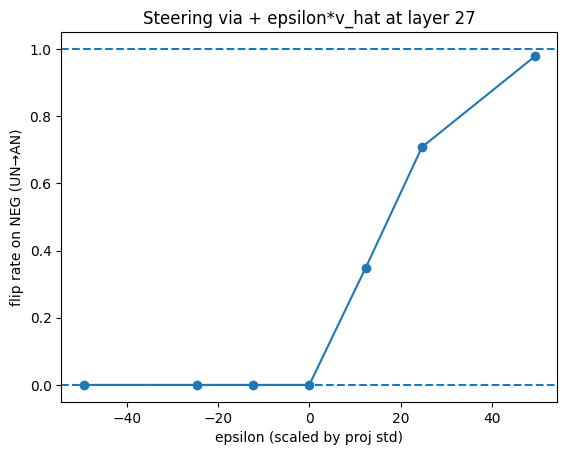

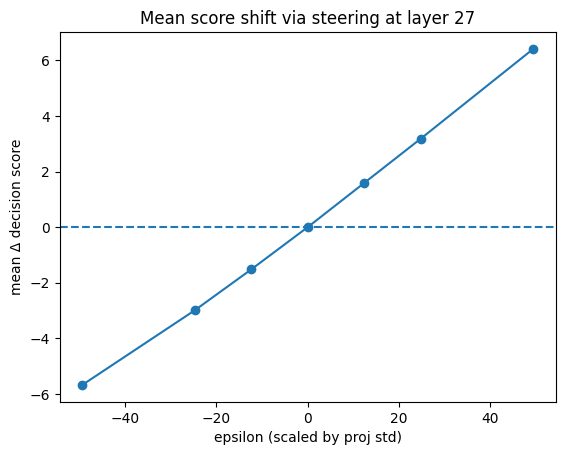

eps_grid: [-49.38967133 -24.69483566 -12.34741783   0.          12.34741783
  24.69483566  49.38967133]
flip_rate: [0.         0.         0.         0.         0.34831461 0.70786517
 0.97752809]
mean_delta: [-5.6805804  -2.98758689 -1.51861401  0.          1.58718906  3.17564203
  6.41339797]


In [ ]:

# compute mean difference direction
mean_pos = Hs[y_pred==1].mean(dim=0)
mean_neg = Hs[y_pred==0].mean(dim=0)
v = (mean_pos - mean_neg)

# normalize direction to unit norm so epsilon has meaningful scale
v_hat = v / (v.norm() + 1e-12)
v_hat = v_hat = v_hat.to(device).to(next(model.parameters()).dtype)


# also estimate a "natural scale" for epsilon from projection std
proj = (Hs.float() @ v_hat.detach().cpu().float()).cpu().numpy()
proj_std = float(np.std(proj))
print("Projection std along v_hat:", proj_std)

# ----------------------------
# 6) Evaluate steering on a held-out set of NEG examples (base score < 0).
#    We measure:
#      - flip rate: how often base<0 becomes patched>0
#      - mean score change
# ----------------------------
N_EVAL = 200
idx_eval = rng.choice(len(df_balanced), size=min(N_EVAL, len(df_balanced)), replace=False)

# collect candidate NEG prompts (base decision is UNANSWERABLE-leaning)
neg_prompts = []
neg_base_scores = []

for i in idx_eval:
    p = make_prompt(df_balanced.loc[i, "context"], df_balanced.loc[i, "question"])
    s0 = decision_score_simple(p)
    if s0 < 0:
        neg_prompts.append(p)
        neg_base_scores.append(s0)

print("NEG eval set size:", len(neg_prompts))

# choose epsilon values relative to proj_std so it's not tiny/huge by accident
# (these are mild-to-strong interventions)
eps_grid = np.array([-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]) * max(proj_std, 1e-3)

flip_rate = []
mean_delta = []

for eps in tqdm(eps_grid, desc="Steering sweep over eps"):
    flips = 0
    deltas = []

    for p, s0 in zip(neg_prompts, neg_base_scores):
        # compute token index for THIS prompt under the same regime
        _, token_index = get_block_output_vec(p, layer_star)

        hook = AddLayerToken(blocks[layer_star], token_index=token_index, direction=v_hat, epsilon=float(eps))
        s1 = decision_score_simple(p, hook=hook)

        deltas.append(s1 - s0)
        if (s0 < 0) and (s1 > 0):
            flips += 1

    flip_rate.append(flips / max(len(neg_prompts), 1))
    mean_delta.append(float(np.mean(deltas)))

flip_rate = np.array(flip_rate)
mean_delta = np.array(mean_delta)

# ----------------------------
# 7) Plot results: flip rate and mean score shift vs epsilon
# ----------------------------
plt.figure()
plt.plot(eps_grid, flip_rate, marker="o")
plt.axhline(0.0, linestyle="--")
plt.axhline(1.0, linestyle="--")
plt.xlabel("epsilon (scaled by proj std)")
plt.ylabel("flip rate on NEG (UN→AN)")
plt.title(f"Steering via + epsilon*v_hat at layer {layer_star}")
plt.ylim(-0.05, 1.05)
plt.show()

plt.figure()
plt.plot(eps_grid, mean_delta, marker="o")
plt.axhline(0.0, linestyle="--")
plt.xlabel("epsilon (scaled by proj std)")
plt.ylabel("mean Δ decision score")
plt.title(f"Mean score shift via steering at layer {layer_star}")
plt.show()

print("eps_grid:", eps_grid)
print("flip_rate:", flip_rate)
print("mean_delta:", mean_delta)


## now for two other layers

In [ ]:

# ----------------------------
# Helper: learn direction v_hat at a specific layer from N_DIR random samples
# ----------------------------
@torch.no_grad()
def learn_direction_at_layer(layer_star: int, N_DIR: int = 200, seed: int = 0):
    rng_local = np.random.default_rng(seed)
    idx = rng_local.choice(len(df_balanced), size=min(N_DIR, len(df_balanced)), replace=False)

    Hs = []
    y_pred_local = []

    for i in tqdm(idx, desc=f"Learn v at layer {layer_star}", leave=False):
        p = make_prompt(df_balanced.loc[i, "context"], df_balanced.loc[i, "question"])
        s = decision_score_simple(p)  # model decision score
        vec, _ = get_block_output_vec(p, layer_star)  # [d_model]
        Hs.append(vec.detach().cpu())
        y_pred_local.append(1 if s > 0 else 0)

    Hs = torch.stack(Hs, dim=0).float()               # force float32 (avoid bf16 issues)
    y_pred_local = np.array(y_pred_local, dtype=int)

    # direction = mean(pos) - mean(neg)
    mean_pos = Hs[y_pred_local == 1].mean(dim=0)
    mean_neg = Hs[y_pred_local == 0].mean(dim=0)
    v = mean_pos - mean_neg
    v_hat = v / (v.norm() + 1e-12)

    # "natural scale" based on projection std
    proj = (Hs @ v_hat).numpy()
    proj_std = float(np.std(proj))

    return v_hat.to(device).to(next(model.parameters()).dtype), proj_std, y_pred_local.sum(), (y_pred_local==0).sum()

# ----------------------------
# Helper: evaluate steering at a given layer for an eps_grid
# ----------------------------
@torch.no_grad()
def eval_steering(layer_star: int, v_hat: torch.Tensor, eps_grid: np.ndarray):
    flip_rate = []
    mean_delta = []

    for eps in tqdm(eps_grid, desc=f"Steer layer {layer_star}", leave=False):
        flips = 0
        deltas = []

        for p, s0 in zip(neg_prompts, neg_base_scores):
            # decision token index for THIS prompt under same regime
            _, token_index = get_block_output_vec(p, layer_star)
            hook = AddLayerToken(blocks[layer_star], token_index=token_index, direction=v_hat, epsilon=float(eps))
            s1 = decision_score_simple(p, hook=hook)

            deltas.append(s1 - s0)
            if s1 > 0:
                flips += 1

        flip_rate.append(flips / len(neg_prompts))
        mean_delta.append(float(np.mean(deltas)))

    return np.array(flip_rate), np.array(mean_delta)


Testing layers: [24, 26, 27]
NEG eval set size: 72


Learn v at layer 24:   0%|          | 0/200 [00:00<?, ?it/s]

Steer layer 24:   0%|          | 0/7 [00:00<?, ?it/s]

Layer 24: proj_std=17.4918  y_pred counts pos=128 neg=72


Learn v at layer 26:   0%|          | 0/200 [00:00<?, ?it/s]

Steer layer 26:   0%|          | 0/7 [00:00<?, ?it/s]

Layer 26: proj_std=23.4512  y_pred counts pos=128 neg=72


Learn v at layer 27:   0%|          | 0/200 [00:00<?, ?it/s]

Steer layer 27:   0%|          | 0/7 [00:00<?, ?it/s]

Layer 27: proj_std=24.6561  y_pred counts pos=128 neg=72


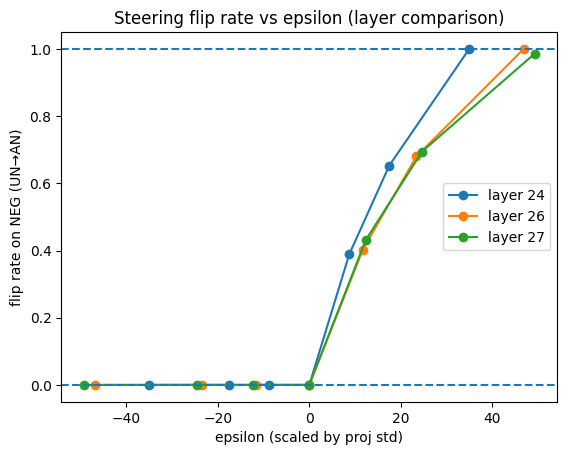

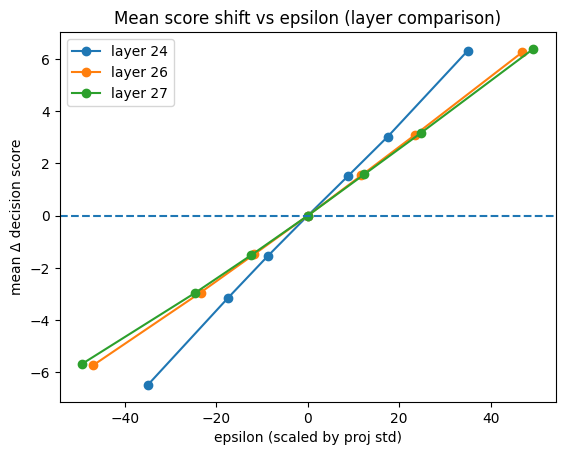

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = model.device
MAXLEN = getattr(model.config, "max_position_embeddings", 2048)

# ---- choose layers to compare ----
layers_to_test = [24, 26, 27]  # you can drop 27 if you want
layers_to_test = [l for l in layers_to_test if l < len(blocks)]
print("Testing layers:", layers_to_test)

# ---- settings ----
N_DIR  = 200   # examples used to learn direction v
N_EVAL = 200   # pool to build NEG eval set from
BASE_SEED = 0
rng = np.random.default_rng(BASE_SEED)

# ----------------------------
# Build a fixed NEG eval set ONCE so all layers are tested on same examples
# ----------------------------
idx_eval = rng.choice(len(df_balanced), size=min(N_EVAL, len(df_balanced)), replace=False)

neg_prompts = []
neg_base_scores = []

for i in idx_eval:
    p = make_prompt(df_balanced.loc[i, "context"], df_balanced.loc[i, "question"])
    s0 = decision_score_simple(p)
    if s0 < 0:
        neg_prompts.append(p)
        neg_base_scores.append(s0)

neg_base_scores = np.array(neg_base_scores, dtype=float)
print("NEG eval set size:", len(neg_prompts))
assert len(neg_prompts) > 10, "Too few NEG examples; increase N_EVAL."

# ----------------------------
# Run the comparison
# ----------------------------
results = {}

for layer_star in layers_to_test:
    v_hat, proj_std, n_pos, n_neg = learn_direction_at_layer(layer_star, N_DIR=N_DIR, seed=BASE_SEED)
    # eps grid scaled by std (same pattern you used)
    scale = max(proj_std, 1e-3)
    eps_grid = np.array([-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]) * scale

    fr, md = eval_steering(layer_star, v_hat, eps_grid)
    results[layer_star] = dict(eps=eps_grid, flip=fr, mean_delta=md, proj_std=proj_std, n_pos=n_pos, n_neg=n_neg)
    print(f"Layer {layer_star}: proj_std={proj_std:.4f}  y_pred counts pos={n_pos} neg={n_neg}")

# ----------------------------
# Plot overlays
# ----------------------------
plt.figure()
for layer_star in layers_to_test:
    r = results[layer_star]
    plt.plot(r["eps"], r["flip"], marker="o", label=f"layer {layer_star}")
plt.axhline(0.0, linestyle="--")
plt.axhline(1.0, linestyle="--")
plt.xlabel("epsilon (scaled by proj std)")
plt.ylabel("flip rate on NEG (UN→AN)")
plt.title("Steering flip rate vs epsilon (layer comparison)")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()

plt.figure()
for layer_star in layers_to_test:
    r = results[layer_star]
    plt.plot(r["eps"], r["mean_delta"], marker="o", label=f"layer {layer_star}")
plt.axhline(0.0, linestyle="--")
plt.xlabel("epsilon (scaled by proj std)")
plt.ylabel("mean Δ decision score")
plt.title("Mean score shift vs epsilon (layer comparison)")
plt.legend()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, json, numpy as np, pandas as pd, torch
from datetime import datetime

RUN_NAME = datetime.now().strftime("uncertainty_%Y%m%d_%H%M%S")
SAVE_DIR = f"/content/drive/MyDrive/mech interp/{RUN_NAME}"
os.makedirs(SAVE_DIR, exist_ok=True)
print("Saving to:", SAVE_DIR)

def save_df(df, name):
    path = os.path.join(SAVE_DIR, f"{name}.parquet")
    df.to_parquet(path, index=False)
    print("saved", path)

def save_npy(arr, name):
    path = os.path.join(SAVE_DIR, f"{name}.npy")
    np.save(path, arr)
    print("saved", path)

def save_npz(**kwargs):
    path = os.path.join(SAVE_DIR, "arrays.npz")
    np.savez(path, **kwargs)
    print("saved", path)

def save_json(obj, name="run_config.json"):
    path = os.path.join(SAVE_DIR, name)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)
    print("saved", path)

# ---- 1) Dataframes ----
for var, nm in [(globals().get("df", None), "df"),
                (globals().get("df_balanced", None), "df_balanced"),
                (globals().get("df_pilot", None), "df_pilot")]:
    if var is not None:
        save_df(var, nm)

# ---- 2) Arrays / labels / scores ----
bundle = {}
for key in ["y_true","y_pred","scores","scores_arr","acc_true","acc_pred",
            "delta_by_layer","flip_rate","flip_rate_rev",
            "eps_grid","mean_delta"]:
    if key in globals() and globals()[key] is not None:
        arr = np.array(globals()[key])
        bundle[key] = arr

# Save X_layers separately (big)
if "X_layers" in globals() and globals()["X_layers"] is not None:
    X = globals()["X_layers"]
    # optional: compress or cast
    save_npy(X.astype(np.float16), "X_layers_fp16")

# Save steering direction
if "v_hat" in globals() and globals()["v_hat"] is not None:
    v = globals()["v_hat"].detach().float().cpu().numpy()
    save_npy(v, "v_hat")

# Save results dict (multi-layer steering) if present
if "results" in globals() and isinstance(globals()["results"], dict):
    # convert to JSON-serializable
    res = {}
    for k,v in globals()["results"].items():
        res[str(k)] = {kk: (vv.tolist() if hasattr(vv, "tolist") else vv) for kk,vv in v.items()}
    save_json(res, "multi_layer_results.json")

# Save main arrays bundle
if len(bundle) > 0:
    save_npz(**bundle)

# ---- 3) Save run config ----
cfg = dict(
    model_name=globals().get("MODEL_NAME", None),
    seed=globals().get("SEED", None),
    maxlen=globals().get("MAXLEN", None),
    truncation_side=getattr(globals().get("tokenizer", None), "truncation_side", None),
    prompt_template_name="ANSWERABLE_UNANSWERABLE_FINAL",
    layer_star=int(globals()["layer_star"]) if "layer_star" in globals() else None,
    proj_std=float(globals()["proj_std"]) if "proj_std" in globals() else None,
    N_DIR=globals().get("N_DIR", None),
    N_EVAL=globals().get("N_EVAL", None),
    N_PAIRS=globals().get("N_PAIRS", None),
)
save_json(cfg)


Mounted at /content/drive
Saving to: /content/drive/MyDrive/mech interp/uncertainty_20251223_092600
saved /content/drive/MyDrive/mech interp/uncertainty_20251223_092600/df.parquet
saved /content/drive/MyDrive/mech interp/uncertainty_20251223_092600/df_balanced.parquet
saved /content/drive/MyDrive/mech interp/uncertainty_20251223_092600/df_pilot.parquet
saved /content/drive/MyDrive/mech interp/uncertainty_20251223_092600/X_layers_fp16.npy
saved /content/drive/MyDrive/mech interp/uncertainty_20251223_092600/v_hat.npy
saved /content/drive/MyDrive/mech interp/uncertainty_20251223_092600/multi_layer_results.json
saved /content/drive/MyDrive/mech interp/uncertainty_20251223_092600/arrays.npz
saved /content/drive/MyDrive/mech interp/uncertainty_20251223_092600/run_config.json


In [ ]:
import json, os, numpy as np

def to_py(o):
    """Convert numpy scalars/arrays/tuples/lists to JSON-serializable Python types."""
    if o is None:
        return None
    if isinstance(o, (np.integer,)):
        return int(o)
    if isinstance(o, (np.floating,)):
        return float(o)
    if isinstance(o, np.ndarray):
        return o.tolist()
    if isinstance(o, (list, tuple)):
        return [to_py(x) for x in o]
    return o  # assume it's already JSON-serializable

payload = {
    "pairs": to_py(pairs) if "pairs" in globals() else None,
    "idx_dir": to_py(idx) if "idx" in globals() else None,
    "idx_eval": to_py(idx_eval) if "idx_eval" in globals() else None,
}

with open(os.path.join(SAVE_DIR, "indices.json"), "w") as f:
    json.dump(payload, f, indent=2)

print("Saved indices.json to", os.path.join(SAVE_DIR, "indices.json"))


Saved indices.json to /content/drive/MyDrive/mech interp/uncertainty_20251223_092600/indices.json


# attention vs mlp



Using layer 26 | attn: <class 'transformers.models.qwen2.modeling_qwen2.Qwen2Attention'> | mlp: <class 'transformers.models.qwen2.modeling_qwen2.Qwen2MLP'>


Learn v_hat @ layer 26:   0%|          | 0/200 [00:00<?, ?it/s]

proj_std: 23.451169967651367 | eps_grid: [-46.90233994 -23.45116997 -11.72558498   0.          11.72558498
  23.45116997  46.90233994]
NEG eval size: 81


eps sweep [block]:   0%|          | 0/7 [00:00<?, ?it/s]

eps sweep [attn]:   0%|          | 0/7 [00:00<?, ?it/s]

eps sweep [mlp]:   0%|          | 0/7 [00:00<?, ?it/s]

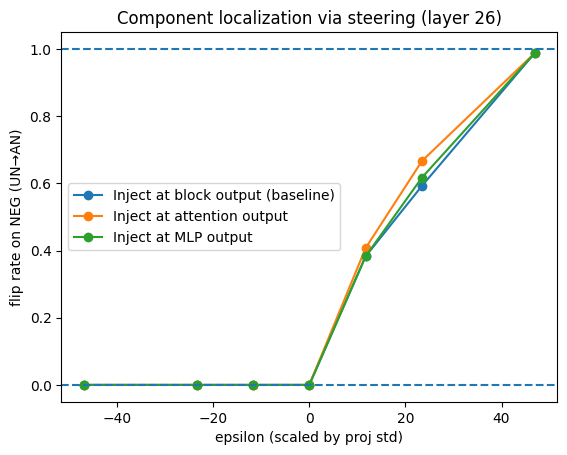

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = model.device
dtype = next(model.parameters()).dtype

# ----------------------------
# 0) Choose a decision-band layer to localize
# ----------------------------
layer_star = 26  # try 24, 26, 27 based on your earlier results
block = blocks[layer_star]

# ----------------------------
# 1) Find submodules inside the block
#    Qwen/LLaMA blocks typically have .self_attn and .mlp
# ----------------------------
if not hasattr(block, "self_attn") or not hasattr(block, "mlp"):
    print("Block missing self_attn/mlp. Available attrs include:")
    print([a for a in dir(block) if "attn" in a.lower() or "mlp" in a.lower()])
    raise ValueError("Need to adapt module names for this architecture.")

attn_mod = block.self_attn
mlp_mod  = block.mlp
print("Using layer", layer_star, "| attn:", type(attn_mod), "| mlp:", type(mlp_mod))

# ----------------------------
# 2) Hook class: add epsilon * v_hat at a module's OUTPUT at token_index
# ----------------------------
class AddAtModuleOutput:
    def __init__(self, module, token_index: int, direction: torch.Tensor, epsilon: float):
        self.module = module
        self.token_index = int(token_index)
        self.direction = direction
        self.epsilon = float(epsilon)
        self.handle = None

    def __enter__(self):
        def hook_fn(mod, inputs, output):
            out = output[0] if isinstance(output, tuple) else output  # [B,T,D]
            if self.token_index >= out.shape[1]:
                return output
            out2 = out.clone()
            out2[0, self.token_index, :] = out2[0, self.token_index, :] + self.epsilon * self.direction
            if isinstance(output, tuple):
                return (out2,) + output[1:]
            return out2

        self.handle = self.module.register_forward_hook(hook_fn)
        return self

    def __exit__(self, exc_type, exc, tb):
        if self.handle is not None:
            self.handle.remove()
        return False

# ----------------------------
# 3) Learn routing direction v_hat at layer_star using y_pred
#    (difference of means of block output vectors at decision token)
# ----------------------------
@torch.no_grad()
def learn_direction_at_layer(layer_star: int, N_DIR: int = 200, seed: int = 0):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(df_balanced), size=min(N_DIR, len(df_balanced)), replace=False)

    Hs = []
    y_pred_local = []

    for i in tqdm(idx, desc=f"Learn v_hat @ layer {layer_star}"):
        p = make_prompt(df_balanced.loc[i, "context"], df_balanced.loc[i, "question"])
        s = decision_score_simple(p)
        vec, _ = get_block_output_vec(p, layer_star)
        Hs.append(vec.detach().cpu())
        y_pred_local.append(1 if s > 0 else 0)

    Hs = torch.stack(Hs, dim=0).float()  # avoid bf16->numpy issues
    y_pred_local = np.array(y_pred_local, dtype=int)

    mean_pos = Hs[y_pred_local == 1].mean(dim=0)
    mean_neg = Hs[y_pred_local == 0].mean(dim=0)
    v = mean_pos - mean_neg
    v_hat = v / (v.norm() + 1e-12)

    proj = (Hs @ v_hat).numpy()
    proj_std = float(np.std(proj))

    v_hat = v_hat.to(device).to(dtype)  # match model dtype
    return v_hat, proj_std

v_hat, proj_std = learn_direction_at_layer(layer_star, N_DIR=200, seed=0)
scale = max(proj_std, 1e-3)
eps_grid = np.array([-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]) * scale
print("proj_std:", proj_std, "| eps_grid:", eps_grid)

# ----------------------------
# 4) Build a NEG eval set (base score < 0)
# ----------------------------
@torch.no_grad()
def build_neg_eval(N_EVAL: int = 200, seed: int = 1):
    rng = np.random.default_rng(seed)
    idx_eval = rng.choice(len(df_balanced), size=min(N_EVAL, len(df_balanced)), replace=False)
    neg_prompts, neg_base_scores = [], []
    for i in idx_eval:
        p = make_prompt(df_balanced.loc[i, "context"], df_balanced.loc[i, "question"])
        s0 = decision_score_simple(p)
        if s0 < 0:
            neg_prompts.append(p)
            neg_base_scores.append(s0)
    return neg_prompts, np.array(neg_base_scores, dtype=float)

neg_prompts, neg_base_scores = build_neg_eval(N_EVAL=200, seed=1)
print("NEG eval size:", len(neg_prompts))
assert len(neg_prompts) >= 10, "Too few NEG examples—bump N_EVAL."

# ----------------------------
# 5) Evaluate flip rate curves for three injection points
# ----------------------------
@torch.no_grad()
def flip_curve(module_kind: str):
    flips = []
    for eps in tqdm(eps_grid, desc=f"eps sweep [{module_kind}]", leave=False):
        n_flip = 0
        for p, s0 in zip(neg_prompts, neg_base_scores):
            _, token_index = get_block_output_vec(p, layer_star)  # decision token index

            if module_kind == "block":
                hook = AddLayerToken(blocks[layer_star], token_index, v_hat, float(eps))
            elif module_kind == "attn":
                hook = AddAtModuleOutput(attn_mod, token_index, v_hat, float(eps))
            elif module_kind == "mlp":
                hook = AddAtModuleOutput(mlp_mod, token_index, v_hat, float(eps))
            else:
                raise ValueError("module_kind must be block/attn/mlp")

            s1 = decision_score_simple(p, hook=hook)
            if s1 > 0:
                n_flip += 1

        flips.append(n_flip / len(neg_prompts))
    return np.array(flips)

flip_block = flip_curve("block")
flip_attn  = flip_curve("attn")
flip_mlp   = flip_curve("mlp")

# ----------------------------
# 6) Plot comparison
# ----------------------------
plt.figure()
plt.plot(eps_grid, flip_block, marker="o", label="Inject at block output (baseline)")
plt.plot(eps_grid, flip_attn,  marker="o", label="Inject at attention output")
plt.plot(eps_grid, flip_mlp,   marker="o", label="Inject at MLP output")
plt.axhline(0.0, linestyle="--")
plt.axhline(1.0, linestyle="--")
plt.xlabel("epsilon (scaled by proj std)")
plt.ylabel("flip rate on NEG (UN→AN)")
plt.title(f"Component localization via steering (layer {layer_star})")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()


# investigatingn individual layers

In [ ]:
import torch
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# Assumptions (from your notebook):
# - blocks = get_transformer_blocks(model)
# - layer_star is set
# - v_hat exists (unit direction in residual stream at layer_star)
# - decision_score_simple(prompt, hook=None) exists (lp(ANS)-lp(UN))
# - build_ids(prompt, completion, max_length) exists
# - ANS = " ANSWERABLE"  and you use completion_for_index=ANS to define token index
# - df_balanced exists and make_prompt(context,question) exists
# ------------------------------------------------------------

def _get_attn_proj_and_meta(block, model):
    """
    Returns: (attn_module, proj_module, num_heads, head_dim, hidden_size)
    Tries to support common HF architectures: Llama, GPT-2, GPT-NeoX.
    """
    # 1) locate attention module and its output projection
    if hasattr(block, "self_attn"):
        attn = block.self_attn
        proj = getattr(attn, "o_proj", None) or getattr(attn, "out_proj", None)
    elif hasattr(block, "attn"):
        attn = block.attn
        proj = getattr(attn, "c_proj", None) or getattr(attn, "out_proj", None)
    elif hasattr(block, "attention"):
        attn = block.attention
        proj = getattr(attn, "dense", None) or getattr(attn, "out_proj", None)
    else:
        raise ValueError("Could not find attention module on this block.")

    if proj is None:
        raise ValueError("Could not find attention output projection module (o_proj/c_proj/dense/out_proj).")

    # 2) infer hidden size
    cfg = getattr(model, "config", None)
    hidden_size = None
    for attr in ["hidden_size", "n_embd", "d_model"]:
        if cfg is not None and hasattr(cfg, attr):
            hidden_size = int(getattr(cfg, attr))
            break
    if hidden_size is None:
        # fallback: proj weight shape is [out, in] typically == [d_model, d_model]
        hidden_size = int(proj.weight.shape[0])

    # 3) infer num_heads
    num_heads = None
    for attr in ["num_heads", "num_attention_heads", "n_heads", "n_head"]:
        if hasattr(attn, attr):
            num_heads = int(getattr(attn, attr))
            break
        if cfg is not None and hasattr(cfg, attr):
            num_heads = int(getattr(cfg, attr))
            break
    if num_heads is None:
        raise ValueError("Could not infer num_heads from attention module or config.")

    # 4) infer head_dim
    head_dim = None
    if hasattr(attn, "head_dim"):
        head_dim = int(getattr(attn, "head_dim"))
    else:
        # common convention
        head_dim = hidden_size // num_heads

    assert head_dim * num_heads == hidden_size, f"head_dim*num_heads != hidden_size ({head_dim}*{num_heads} != {hidden_size})"

    return attn, proj, num_heads, head_dim, hidden_size


def _decision_token_index(prompt: str, completion_for_index: str = ANS, max_length: int = MAXLEN):
    # Must match your existing regime: decision token = last token of (possibly truncated) prompt
    input_ids, prompt_len, comp_len = build_ids(prompt, completion_for_index, max_length=max_length)
    return prompt_len - 1


class ZeroHeadsAtToken:
    """
    Forward PRE-hook on attention output projection.
    Zeros selected head slices of the projection input at a single token position.
    This is a causal head ablation (at the point where heads are concatenated).
    """
    def __init__(self, proj_module, token_index: int, heads_to_zero, head_dim: int):
        self.proj = proj_module
        self.tok = int(token_index)
        self.heads = list(map(int, heads_to_zero))
        self.head_dim = int(head_dim)
        self.handle = None

        # precompute slices
        self.slices = [(h*self.head_dim, (h+1)*self.head_dim) for h in self.heads]

    def _pre_hook(self, module, inputs):
        # inputs[0] expected: x with shape [B, T, hidden_size]
        x = inputs[0]
        if x.dim() != 3:
            return inputs
        # clone the specific token vector to avoid in-place issues
        x2 = x.clone()
        for a, b in self.slices:
            x2[:, self.tok, a:b] = 0
        return (x2,) + inputs[1:]

    def __enter__(self):
        self.handle = self.proj.register_forward_pre_hook(self._pre_hook)
        return self

    def __exit__(self, exc_type, exc, tb):
        if self.handle is not None:
            self.handle.remove()
        return False


@torch.no_grad()
def rank_heads_by_direction_alignment(
    prompts,
    block,
    model,
    v_hat,
    max_prompts: int = 128,
    completion_for_index: str = ANS,
):
    """
    Cheap head ranking:
    Capture x = input to attn out-proj at decision token (concatenated heads).
    Each head contributes: y_h = W[:, slice_h] @ x_slice_h  (post-proj contribution in d_model space)
    Score alignment: <v_hat, y_h>
    We return per-head mean alignment and can compare pos vs neg subsets later.
    """
    attn, proj, n_heads, head_dim, hidden_size = _get_attn_proj_and_meta(block, model)
    W = proj.weight.detach()  # [d_model, d_model] typically

    # capture helper
    captured = []

    def pre_hook_capture(module, inputs):
        x = inputs[0]  # [B,T,H]
        captured.append(x.detach())
        return inputs

    handle = proj.register_forward_pre_hook(pre_hook_capture)

    # run a small set
    use_prompts = prompts[:max_prompts]
    token_idxs = []
    for p in use_prompts:
        tok = _decision_token_index(p, completion_for_index=completion_for_index)
        token_idxs.append(tok)
        # one forward pass is enough; we just need x at proj input
        _ = logprob_completion(p, ANS, hook=None, max_length=MAXLEN)  # triggers forward; uses your stable regime

    handle.remove()

    # compute per-head alignments
    # v_hat should be [d_model]
    v = v_hat.detach().to(W.device).to(W.dtype)

    rows = []
    for i, x_full in enumerate(captured):
        # x_full shape [1, T, H] in your usage
        x_tok = x_full[0, token_idxs[i], :]  # [H]
        # per head
        for h in range(n_heads):
            a, b = h*head_dim, (h+1)*head_dim
            xh = x_tok[a:b]                    # [head_dim]
            # y_h = W[:, a:b] @ xh
            yh = torch.matmul(W[:, a:b], xh)   # [d_model]
            align = torch.dot(v, yh).item()
            rows.append((i, h, align))

    df = pd.DataFrame(rows, columns=["example_i", "head", "align"])
    summary = df.groupby("head")["align"].mean().reset_index().sort_values("align", ascending=False)
    return summary, (attn, proj, n_heads, head_dim, hidden_size)


@torch.no_grad()
def causal_ablate_heads(
    prompts,
    block,
    model,
    heads,
    subset_name="",
    max_prompts: int = 64,
):
    """
    Causal evaluation:
    For each prompt, compute base score s0.
    Then ablate selected heads at decision token and compute s1.
    Report mean delta and flip rates.
    """
    attn, proj, n_heads, head_dim, hidden_size = _get_attn_proj_and_meta(block, model)

    use_prompts = prompts[:max_prompts]
    deltas = []
    flips_neg_to_pos = 0
    flips_pos_to_neg = 0
    n_neg = 0
    n_pos = 0

    for p in use_prompts:
        tok = _decision_token_index(p, completion_for_index=ANS)
        s0 = decision_score_simple(p, hook=None)

        with ZeroHeadsAtToken(proj, token_index=tok, heads_to_zero=heads, head_dim=head_dim):
            s1 = decision_score_simple(p, hook=None)  # hook is active via context manager

        deltas.append(s1 - s0)

        if s0 < 0:
            n_neg += 1
            if s1 > 0:
                flips_neg_to_pos += 1
        else:
            n_pos += 1
            if s1 < 0:
                flips_pos_to_neg += 1

    return {
        "subset": subset_name,
        "heads": list(map(int, heads)),
        "n": len(use_prompts),
        "mean_delta": float(np.mean(deltas)) if len(deltas) else np.nan,
        "median_delta": float(np.median(deltas)) if len(deltas) else np.nan,
        "neg_to_pos_flip_rate": (flips_neg_to_pos / max(1, n_neg)),
        "pos_to_neg_flip_rate": (flips_pos_to_neg / max(1, n_pos)),
        "n_neg": n_neg,
        "n_pos": n_pos,
    }


# ------------------------------------------------------------
# 2) Build eval prompt subsets (UNANSWERABLE-leaning and ANSWERABLE-leaning)
# ------------------------------------------------------------
rng = np.random.default_rng(0)

all_prompts = [make_prompt(c, q) for c, q in zip(df_balanced["context"], df_balanced["question"])]

# Compute a quick base score to split (keep small for speed; increase later)
N_SPLIT = min(256, len(all_prompts))
idx_split = rng.choice(len(all_prompts), size=N_SPLIT, replace=False)

split_prompts = []
split_scores = []
for i in idx_split:
    p = all_prompts[i]
    s = decision_score_simple(p, hook=None)
    split_prompts.append(p)
    split_scores.append(s)

neg_prompts = [p for p, s in zip(split_prompts, split_scores) if s < 0]
pos_prompts = [p for p, s in zip(split_prompts, split_scores) if s > 0]

print(f"Split set sizes: neg={len(neg_prompts)} pos={len(pos_prompts)} (N_SPLIT={N_SPLIT})")

# ------------------------------------------------------------
# 3) Rank heads by alignment with v_hat (cheap) on the neg subset
# ------------------------------------------------------------
block = blocks[layer_star]
head_rank, meta = rank_heads_by_direction_alignment(
    prompts=neg_prompts if len(neg_prompts) else split_prompts,
    block=block,
    model=model,
    v_hat=v_hat,
    max_prompts=min(128, len(neg_prompts) if len(neg_prompts) else len(split_prompts)),
)

print("Top 15 heads by alignment (higher means contributes more in +v_hat direction):")
display(head_rank.head(15))

# Choose top-K to test causally
TOPK = 8
top_heads = head_rank["head"].head(TOPK).tolist()
print("Testing top_heads =", top_heads)

# ------------------------------------------------------------
# 4) Causal head ablation tests (necessity-style)
# ------------------------------------------------------------
res_neg = causal_ablate_heads(
    prompts=neg_prompts,
    block=block,
    model=model,
    heads=top_heads,
    subset_name="NEG (base score < 0)",
    max_prompts=min(64, len(neg_prompts)),
)

res_pos = causal_ablate_heads(
    prompts=pos_prompts,
    block=block,
    model=model,
    heads=top_heads,
    subset_name="POS (base score > 0)",
    max_prompts=min(64, len(pos_prompts)),
)

print(pd.DataFrame([res_neg, res_pos]))


Split set sizes: neg=100 pos=156 (N_SPLIT=256)
Top 15 heads by alignment (higher means contributes more in +v_hat direction):


,head,align
10,10,0.967803
6,6,0.406790
9,9,-0.196226
5,5,-0.223484
0,0,-0.293145
1,1,-0.535957
11,11,-0.638945
8,8,-0.651602
3,3,-0.721367
2,2,-0.826118


Testing top_heads = [10, 6, 9, 5, 0, 1, 11, 8]
                 subset                       heads   n  mean_delta  \
0  NEG (base score < 0)  [10, 6, 9, 5, 0, 1, 11, 8]  64   -0.692331   
1  POS (base score > 0)  [10, 6, 9, 5, 0, 1, 11, 8]  64   -1.307432   

   median_delta  neg_to_pos_flip_rate  pos_to_neg_flip_rate  n_neg  n_pos  
0     -0.632996                   0.0               0.00000     64      0  
1     -1.258057                   0.0               0.09375      0     64  


## ablation ladder

In [ ]:
import numpy as np
import pandas as pd

import json, torch

with open("/content/drive/MyDrive/mech interp/mech_interp_artifacts/artifact_layer26.json", "r") as f:
    A = json.load(f)

layer_star = A["layer_star"]
pos_heads = A["heads"]["pos_align_heads"]
neg_heads = A["heads"]["neg_align_heads"]

v_hat = torch.load(A["direction"]["v_hat_path"], map_location="cpu")["v_hat"]
v_hat = v_hat.to(model.device).to(next(model.parameters()).dtype)

import json
import numpy as np

with open("/content/drive/MyDrive/mech interp/mech_interp_artifacts/eval_bundle_seed123.json", "r") as f:
    D = json.load(f)["bundle"]

pos_idx = D["pos_idx"]
neg_idx = D["neg_idx"]

pos_prompts = [make_prompt(df_balanced.loc[i, "context"], df_balanced.loc[i, "question"]) for i in pos_idx]
neg_prompts = [make_prompt(df_balanced.loc[i, "context"], df_balanced.loc[i, "question"]) for i in neg_idx]

pos_base_scores = np.array(D["pos_base_scores"], dtype=float)
neg_base_scores = np.array(D["neg_base_scores"], dtype=float)

print("Reconstructed:", len(pos_prompts), "pos prompts,", len(neg_prompts), "neg prompts")



Ks = [1, 2, 3, 4, 6, 8]

pos_heads = A["heads"]["pos_align_heads"]  # or however you loaded them
neg_heads = A["heads"]["neg_align_heads"]

results = []

# --- +align ladder: expect POS->NEG flips
for K in Ks:
    headsK = pos_heads[:K]
    if len(headsK) == 0:
        continue
    results.append(causal_ablate_heads(
        pos_prompts, blocks[layer_star], model, headsK,
        subset_name=f"POS ablate +align K={K}", max_prompts=min(64, len(pos_prompts))
    ))
    results.append(causal_ablate_heads(
        neg_prompts, blocks[layer_star], model, headsK,
        subset_name=f"NEG ablate +align K={K}", max_prompts=min(64, len(neg_prompts))
    ))

# --- -align ladder: expect NEG->POS flips
for K in Ks:
    headsK = neg_heads[:K]
    results.append(causal_ablate_heads(
        neg_prompts, blocks[layer_star], model, headsK,
        subset_name=f"NEG ablate -align K={K}", max_prompts=min(64, len(neg_prompts))
    ))
    results.append(causal_ablate_heads(
        pos_prompts, blocks[layer_star], model, headsK,
        subset_name=f"POS ablate -align K={K}", max_prompts=min(64, len(pos_prompts))
    ))

# --- random baseline ladder: repeat a few seeds (very important control)
n_heads_total = len(A["heads"]["head_rank"])
seeds = [0, 1, 2, 3, 4]
for seed in seeds:
    rng = np.random.default_rng(seed)
    for K in Ks:
        rand_heads = rng.choice(n_heads_total, size=min(K, n_heads_total), replace=False).tolist()
        results.append(causal_ablate_heads(
            neg_prompts, blocks[layer_star], model, rand_heads,
            subset_name=f"NEG ablate RANDOM(seed={seed}) K={K}", max_prompts=min(64, len(neg_prompts))
        ))

df = pd.DataFrame(results)
display(df)


Reconstructed: 180 pos prompts, 120 neg prompts


KeyboardInterrupt: 

In [ ]:
import os, json, time, torch, pandas as pd

SAVE_DIR = "/content/drive/MyDrive/mech interp/checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

stamp = time.strftime("%Y%m%d_%H%M%S")
save_prefix = os.path.join(SAVE_DIR, f"run_{stamp}")

# Save any partial results you have
try:
    pd.DataFrame(results).to_csv(save_prefix + "_partial_results.csv", index=False)
    print("Saved partial results CSV:", save_prefix + "_partial_results.csv")
except Exception as e:
    print("No results to save yet (or error):", e)

# Save metadata you already loaded (even if mismatched)
meta = {
    "timestamp": stamp,
    "artifact_json_path": "/content/drive/MyDrive/mech interp/mech_interp_artifacts/artifact_layer26.json",
    "eval_bundle_path": "/content/drive/MyDrive/mech interp/mech_interp_artifacts/eval_bundle_seed123.json",
    "layer_star": int(layer_star) if "layer_star" in globals() else None,
    "Ks": Ks if "Ks" in globals() else None,
    "seeds": seeds if "seeds" in globals() else None,
    "note": "This run used an eval bundle that later appeared mismatched vs current runtime scores."
}
with open(save_prefix + "_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
print("Saved meta JSON:", save_prefix + "_meta.json")

# Save v_hat currently loaded (so you can compare later)
try:
    torch.save({"v_hat": v_hat.detach().cpu().float()}, save_prefix + "_vhat.pt")
    print("Saved v_hat:", save_prefix + "_vhat.pt")
except Exception as e:
    print("Could not save v_hat:", e)


Saved partial results CSV: /content/drive/MyDrive/mech interp/checkpoints/run_20251223_194229_partial_results.csv
Saved meta JSON: /content/drive/MyDrive/mech interp/checkpoints/run_20251223_194229_meta.json
Saved v_hat: /content/drive/MyDrive/mech interp/checkpoints/run_20251223_194229_vhat.pt


In [ ]:
import numpy as np
import torch

def _get_proj_and_headmeta(block, model):
    _, proj, n_heads, head_dim, _ = _get_attn_proj_and_meta(block, model)
    return proj, n_heads, head_dim

class PatchHeadsAtToken:
    """
    Forward PRE-hook on attention out-proj.
    Replaces selected head slices of the proj input at one token with donor values.
    """
    def __init__(self, proj_module, token_index: int, heads, head_dim: int, donor_x_tok: torch.Tensor):
        self.proj = proj_module
        self.tok = int(token_index)
        self.heads = [int(h) for h in heads]
        self.head_dim = int(head_dim)
        self.donor_x_tok = donor_x_tok  # shape [H]
        self.handle = None
        self.slices = [(h*self.head_dim, (h+1)*self.head_dim) for h in self.heads]

    def _pre_hook(self, module, inputs):
        x = inputs[0]  # [B,T,H]
        if x.dim() != 3 or self.tok >= x.shape[1]:
            return inputs
        x2 = x.clone()
        for a, b in self.slices:
            x2[:, self.tok, a:b] = self.donor_x_tok[a:b]
        return (x2,) + inputs[1:]

    def __enter__(self):
        self.handle = self.proj.register_forward_pre_hook(self._pre_hook)
        return self

    def __exit__(self, exc_type, exc, tb):
        if self.handle is not None:
            self.handle.remove()
        return False


@torch.no_grad()
def capture_proj_input_at_token(prompt: str, block, model):
    """
    Returns donor vector x_tok = input to attn out-proj at the decision token.
    """
    _, proj, _, _, _ = _get_attn_proj_and_meta(block, model)
    tok = _decision_token_index(prompt)

    captured = {"x": None}

    def pre_hook_capture(module, inputs):
        x = inputs[0]          # [B,T,H]
        captured["x"] = x.detach()
        return inputs

    h = proj.register_forward_pre_hook(pre_hook_capture)
    _ = decision_score_simple(prompt, hook=None)  # just to run forward
    h.remove()

    x_tok = captured["x"][0, tok, :].clone()      # [H]
    return x_tok


@torch.no_grad()
def sufficiency_patch_eval(neg_prompts, pos_prompts, heads, block, model, n_pairs=64, seed=0):
    """
    For each pair (neg, pos), patch selected heads at decision token using donor from pos into neg.
    Measure: flip rate and score deltas.
    """
    rng = np.random.default_rng(seed)
    n_pairs = min(n_pairs, len(neg_prompts), len(pos_prompts))
    neg_idxs = rng.choice(len(neg_prompts), size=n_pairs, replace=False)
    pos_idxs = rng.choice(len(pos_prompts), size=n_pairs, replace=False)

    proj, _, head_dim = _get_proj_and_headmeta(block, model)

    flips = 0
    deltas = []

    for ni, pi in zip(neg_idxs, pos_idxs):
        p_neg = neg_prompts[ni]
        p_pos = pos_prompts[pi]

        # baseline
        s0 = decision_score_simple(p_neg, hook=None)

        # donor capture from pos
        donor_x_tok = capture_proj_input_at_token(p_pos, block, model).to(proj.weight.device).to(proj.weight.dtype)

        tok = _decision_token_index(p_neg)

        with PatchHeadsAtToken(proj, token_index=tok, heads=heads, head_dim=head_dim, donor_x_tok=donor_x_tok):
            s1 = decision_score_simple(p_neg, hook=None)

        deltas.append(float(s1 - s0))
        if s0 < 0 and s1 > 0:
            flips += 1

    return {
        "heads": heads,
        "n_pairs": n_pairs,
        "neg_to_pos_flip_rate": flips / max(1, n_pairs),
        "mean_delta": float(np.mean(deltas)) if deltas else np.nan,
        "median_delta": float(np.median(deltas)) if deltas else np.nan,
    }


# quick tests

In [ ]:
import numpy as np

@torch.no_grad()
def rebuild_pos_neg_prompts(N=400, seed=0):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(df_balanced), size=min(N, len(df_balanced)), replace=False)

    pos_prompts, neg_prompts = [], []
    pos_scores, neg_scores = [], []

    for i in idx:
        p = make_prompt(df_balanced.loc[i, "context"], df_balanced.loc[i, "question"])
        s = float(decision_score_simple(p, hook=None))
        if s > 0:
            pos_prompts.append(p); pos_scores.append(s)
        elif s < 0:
            neg_prompts.append(p); neg_scores.append(s)

    return pos_prompts, np.array(pos_scores), neg_prompts, np.array(neg_scores)

pos_prompts, pos_base_scores, neg_prompts, neg_base_scores = rebuild_pos_neg_prompts(N=400, seed=0)
print("rebuilt:", len(pos_prompts), "pos |", len(neg_prompts), "neg")


rebuilt: 233 pos | 167 neg


In [ ]:
v_hat, proj_std = learn_direction_at_layer(layer_star, N_DIR=200, seed=0)
print("proj_std:", proj_std)


Learn v_hat @ layer 26:   0%|          | 0/200 [00:00<?, ?it/s]

proj_std: 23.451169967651367


In [ ]:
rank_df, meta = rank_heads_by_direction_alignment(
    prompts=neg_prompts,
    block=blocks[layer_star],
    model=model,
    v_hat=v_hat,
    max_prompts=min(128, len(neg_prompts)),
)
rank_df = rank_df.sort_values("align", ascending=False).reset_index(drop=True)
pos_heads = rank_df[rank_df["align"] > 0]["head"].tolist()
neg_heads = rank_df.sort_values("align", ascending=True)["head"].tolist()
print("pos_heads:", pos_heads[:6])
print("neg_heads:", neg_heads[:6])


pos_heads: [10, 6]
neg_heads: [7, 4, 2, 3, 8, 11]


In [ ]:
import numpy as np
import pandas as pd

# Keep it small for speed; scale later only on the winning K
Ks = [1, 2, 3, 4, 6]
MAXP = 16            # << fast; use 32/64 later once you see signal
RAND_SEEDS = [0, 1]  # << enough for a control at this stage

results = []

# --- +align ladder: expect POS->NEG flips
for K in Ks:
    print("K: ", K)
    headsK = pos_heads[:K]
    if len(headsK) == 0:
        continue
    results.append(causal_ablate_heads(
        prompts=pos_prompts, block=blocks[layer_star], model=model, heads=headsK,
        subset_name=f"POS +align K={K}", max_prompts=min(MAXP, len(pos_prompts))
    ))
    results.append(causal_ablate_heads(
        prompts=neg_prompts, block=blocks[layer_star], model=model, heads=headsK,
        subset_name=f"NEG +align K={K}", max_prompts=min(MAXP, len(neg_prompts))
    ))

# --- -align ladder: expect NEG->POS flips
for K in Ks:
    print("K: ", K)
    headsK = neg_heads[:K]
    results.append(causal_ablate_heads(
        prompts=neg_prompts, block=blocks[layer_star], model=model, heads=headsK,
        subset_name=f"NEG -align K={K}", max_prompts=min(MAXP, len(neg_prompts))
    ))
    results.append(causal_ablate_heads(
        prompts=pos_prompts, block=blocks[layer_star], model=model, heads=headsK,
        subset_name=f"POS -align K={K}", max_prompts=min(MAXP, len(pos_prompts))
    ))

# --- Random baseline (NEG only): cheap specificity check
n_heads_total = int(getattr(model.config, "num_attention_heads", len(rank_df)))  # fallback ok
# Better: number of heads in THIS layer from rank_df:
n_heads_total = len(rank_df)

for seed in RAND_SEEDS:
    rng = np.random.default_rng(seed)
    for K in Ks:
        rand_heads = rng.choice(n_heads_total, size=min(K, n_heads_total), replace=False).tolist()
        results.append(causal_ablate_heads(
            prompts=neg_prompts, block=blocks[layer_star], model=model, heads=rand_heads,
            subset_name=f"NEG RANDOM(seed={seed}) K={K}", max_prompts=min(MAXP, len(neg_prompts))
        ))

df_small = pd.DataFrame(results)
display(df_small)


K:  1
K:  2
K:  3
K:  4
K:  6
K:  1
K:  2
K:  3
K:  4
K:  6


,subset,heads,n,mean_delta,median_delta,neg_to_pos_flip_rate,pos_to_neg_flip_rate,n_neg,n_pos
0,POS +align K=1,[10],16,-0.101196,-0.121948,0.0000,0.0,0,16
1,NEG +align K=1,[10],16,-0.054581,-0.058594,0.0000,0.0,16,0
2,POS +align K=2,"[10, 6]",16,-0.311951,-0.260498,0.0000,0.0,0,16
3,NEG +align K=2,"[10, 6]",16,-0.178391,-0.235229,0.0000,0.0,16,0
4,POS +align K=3,"[10, 6]",16,-0.311951,-0.260498,0.0000,0.0,0,16
5,NEG +align K=3,"[10, 6]",16,-0.178391,-0.235229,0.0000,0.0,16,0
6,POS +align K=4,"[10, 6]",16,-0.311951,-0.260498,0.0000,0.0,0,16
7,NEG +align K=4,"[10, 6]",16,-0.178391,-0.235229,0.0000,0.0,16,0
8,POS +align K=6,"[10, 6]",16,-0.311951,-0.260498,0.0000,0.0,0,16
9,NEG +align K=6,"[10, 6]",16,-0.178391,-0.235229,0.0000,0.0,16,0


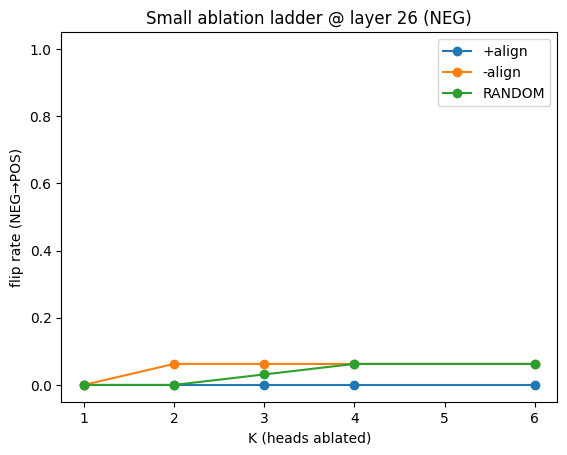

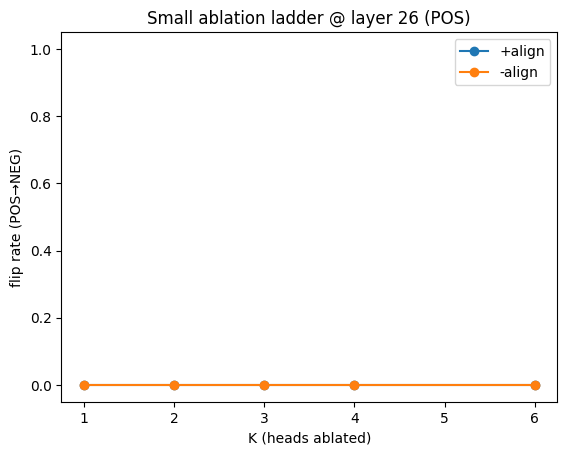

In [ ]:
import matplotlib.pyplot as plt

def plot_ladders(df):
    df = df.copy()

    # Parse K and condition from subset_name strings
    df["K"] = df["subset"].str.extract(r"K=(\d+)").astype(int)
    df["side"] = df["subset"].str.extract(r"^(NEG|POS)")
    df["kind"] = df["subset"].apply(lambda s: "+align" if "+align" in s else ("-align" if "-align" in s else "RANDOM"))

    # Use the relevant flip metric depending on POS/NEG
    df["flip"] = df.apply(lambda r: r["neg_to_pos_flip_rate"] if r["side"]=="NEG" else r["pos_to_neg_flip_rate"], axis=1)

    for side in ["NEG", "POS"]:
        plt.figure()
        for kind in ["+align", "-align", "RANDOM"]:
            sub = df[(df["side"]==side) & (df["kind"]==kind)]
            if len(sub)==0:
                continue
            g = sub.groupby("K")["flip"].mean().reset_index().sort_values("K")
            plt.plot(g["K"], g["flip"], marker="o", label=kind)
        plt.ylim(-0.05, 1.05)
        plt.xlabel("K (heads ablated)")
        plt.ylabel("flip rate" + (" (NEG→POS)" if side=="NEG" else " (POS→NEG)"))
        plt.title(f"Small ablation ladder @ layer {layer_star} ({side})")
        plt.legend()
        plt.show()

plot_ladders(df_small)


# borderline plots

In [ ]:
import numpy as np

# Recompute scores once (or use cached arrays if you have them aligned)
pos_s = np.array([float(decision_score_simple(p)) for p in pos_prompts])
neg_s = np.array([float(decision_score_simple(p)) for p in neg_prompts])

POS_BAND = 0.8
NEG_BAND = 0.8

pos_band = [p for p, s in zip(pos_prompts, pos_s) if 0.0 < s < POS_BAND]
neg_band = [p for p, s in zip(neg_prompts, neg_s) if -NEG_BAND < s < 0.0]

print("borderline pos:", len(pos_band), "borderline neg:", len(neg_band))


borderline pos: 20 borderline neg: 34


In [ ]:
import numpy as np
import pandas as pd

# Use only what exists
Ks_pos = [1, 2] if len(pos_heads) <= 2 else [1, 2, 3, 4, 6]
Ks_neg = [1, 2, 3, 4, 6]

MAXP = 32                    # borderline sets are small; 32 is fine
RAND_SEEDS = [0, 1, 2, 3, 4] # to average out noise

results = []

# +align ladder (POSband should flip more than random if these are "answerable heads")
for K in Ks_pos:
    headsK = pos_heads[:K]
    results.append(causal_ablate_heads(
        prompts=pos_band, block=blocks[layer_star], model=model, heads=headsK,
        subset_name=f"POSband +align K={K}", max_prompts=min(MAXP, len(pos_band))
    ))
    results.append(causal_ablate_heads(
        prompts=neg_band, block=blocks[layer_star], model=model, heads=headsK,
        subset_name=f"NEGband +align K={K}", max_prompts=min(MAXP, len(neg_band))
    ))

# -align ladder (NEGband should flip more than random if these are "unanswerable heads")
for K in Ks_neg:
    headsK = neg_heads[:K]
    results.append(causal_ablate_heads(
        prompts=neg_band, block=blocks[layer_star], model=model, heads=headsK,
        subset_name=f"NEGband -align K={K}", max_prompts=min(MAXP, len(neg_band))
    ))
    results.append(causal_ablate_heads(
        prompts=pos_band, block=blocks[layer_star], model=model, heads=headsK,
        subset_name=f"POSband -align K={K}", max_prompts=min(MAXP, len(pos_band))
    ))

# Random baseline (NEG band only is enough)
n_heads_total = len(rank_df)
for seed in RAND_SEEDS:
    rng = np.random.default_rng(seed)
    for K in Ks_neg:
        rand_heads = rng.choice(n_heads_total, size=min(K, n_heads_total), replace=False).tolist()
        results.append(causal_ablate_heads(
            prompts=neg_band, block=blocks[layer_star], model=model, heads=rand_heads,
            subset_name=f"NEGband RANDOM(seed={seed}) K={K}",
            max_prompts=min(MAXP, len(neg_band))
        ))

df_band = pd.DataFrame(results)
display(df_band)


,subset,heads,n,mean_delta,median_delta,neg_to_pos_flip_rate,pos_to_neg_flip_rate,n_neg,n_pos
0,POSband +align K=1,[10],20,-0.057422,-0.066406,0.00000,0.15,0,20
1,NEGband +align K=1,[10],32,-0.039001,0.000000,0.00000,0.00,32,0
2,POSband +align K=2,"[10, 6]",20,-0.168750,-0.125000,0.00000,0.15,0,20
3,NEGband +align K=2,"[10, 6]",32,-0.160828,-0.127930,0.00000,0.00,32,0
4,NEGband -align K=1,[7],32,-0.121094,-0.125000,0.00000,0.00,32,0
5,POSband -align K=1,[7],20,-0.107422,-0.125000,0.00000,0.15,0,20
6,NEGband -align K=2,"[7, 4]",32,0.272949,0.250000,0.37500,0.00,32,0
7,POSband -align K=2,"[7, 4]",20,0.288184,0.250000,0.00000,0.00,0,20
8,NEGband -align K=3,"[7, 4, 2]",32,0.152100,0.125000,0.21875,0.00,32,0
9,POSband -align K=3,"[7, 4, 2]",20,0.293555,0.250000,0.00000,0.00,0,20


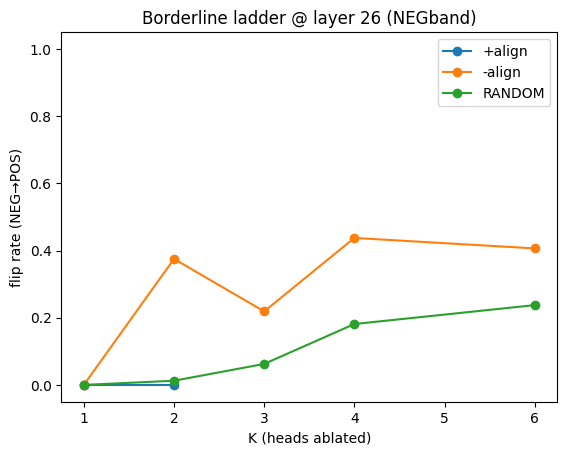

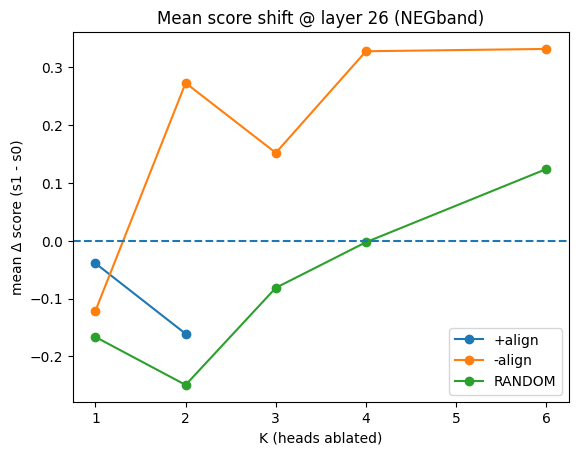

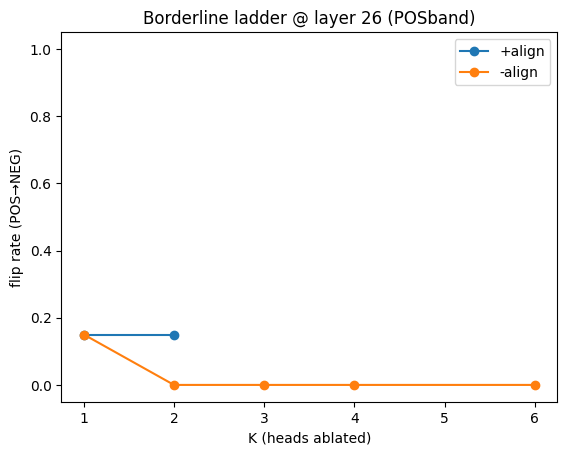

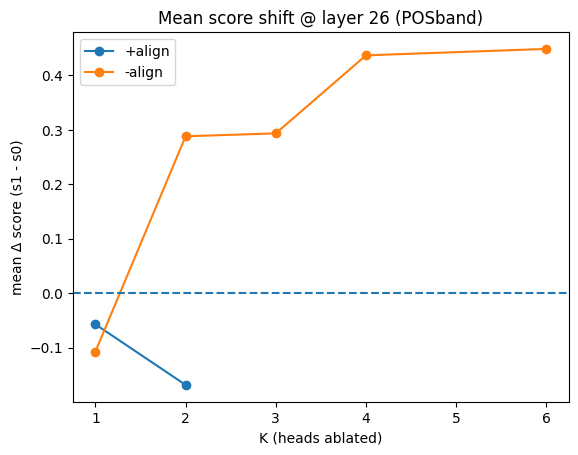

In [ ]:
import matplotlib.pyplot as plt

def plot_band(df, side="NEGband"):
    df = df.copy()
    df = df[df["subset"].str.startswith(side)].copy()
    df["K"] = df["subset"].str.extract(r"K=(\d+)").astype(int)
    df["kind"] = df["subset"].apply(lambda s: "+align" if "+align" in s else ("-align" if "-align" in s else "RANDOM"))

    # flip metric depends on side
    if side.startswith("NEG"):
        df["flip"] = df["neg_to_pos_flip_rate"]
    else:
        df["flip"] = df["pos_to_neg_flip_rate"]

    # Average RANDOM over seeds, keep others as-is
    def agg_mean(x): return x.mean()

    # Flip plot
    plt.figure()
    for kind in ["+align","-align","RANDOM"]:
        sub = df[df["kind"]==kind]
        if len(sub)==0:
            continue
        g = sub.groupby("K")["flip"].apply(agg_mean).reset_index().sort_values("K")
        plt.plot(g["K"], g["flip"], marker="o", label=kind)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("K (heads ablated)")
    plt.ylabel("flip rate" + (" (NEG→POS)" if side.startswith("NEG") else " (POS→NEG)"))
    plt.title(f"Borderline ladder @ layer {layer_star} ({side})")
    plt.legend()
    plt.show()

    # Mean delta plot (less noisy)
    plt.figure()
    for kind in ["+align","-align","RANDOM"]:
        sub = df[df["kind"]==kind]
        if len(sub)==0:
            continue
        g = sub.groupby("K")["mean_delta"].apply(agg_mean).reset_index().sort_values("K")
        plt.plot(g["K"], g["mean_delta"], marker="o", label=kind)
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("K (heads ablated)")
    plt.ylabel("mean Δ score (s1 - s0)")
    plt.title(f"Mean score shift @ layer {layer_star} ({side})")
    plt.legend()
    plt.show()

plot_band(df_band, side="NEGband")
plot_band(df_band, side="POSband")


In [ ]:
print("h")

h


In [ ]:
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

HEADS = [7, 4]   # your minimal K=2 candidate
K = len(HEADS)

def _get_attn_outproj(block, model):
    # attention module
    if hasattr(block, "self_attn"): attn = block.self_attn
    elif hasattr(block, "attn"): attn = block.attn
    elif hasattr(block, "attention"): attn = block.attention
    else: raise ValueError("Can't find attention module on block.")

    # out projection module
    outproj = None
    for name in ["o_proj", "out_proj", "c_proj", "dense"]:
        if hasattr(attn, name):
            outproj = getattr(attn, name)
            if outproj is not None:
                break
    if outproj is None:
        raise ValueError("Can't find out projection (o_proj/out_proj/c_proj/dense).")

    # infer num_heads / hidden / head_dim
    cfg = getattr(model, "config", None)
    num_heads = None
    for attr in ["num_attention_heads", "num_heads", "n_heads", "n_head"]:
        if hasattr(attn, attr):
            num_heads = int(getattr(attn, attr)); break
        if cfg is not None and hasattr(cfg, attr):
            num_heads = int(getattr(cfg, attr)); break
    if num_heads is None:
        raise ValueError("Couldn't infer num_heads.")

    hidden = None
    for attr in ["hidden_size", "n_embd", "d_model"]:
        if cfg is not None and hasattr(cfg, attr):
            hidden = int(getattr(cfg, attr)); break
    if hidden is None:
        hidden = int(outproj.weight.shape[0])

    head_dim = int(getattr(attn, "head_dim", hidden // num_heads))
    assert head_dim * num_heads == hidden
    return attn, outproj, num_heads, head_dim, hidden

attn, outproj, NUM_HEADS, HEAD_DIM, HIDDEN = _get_attn_outproj(blocks[layer_star], model)
print("layer", layer_star, "| NUM_HEADS", NUM_HEADS, "| HEAD_DIM", HEAD_DIM, "| HIDDEN", HIDDEN)

def _encode(prompt):
    return tokenizer(prompt, return_tensors="pt").to(model.device)

def _tokens(prompt):
    ids = _encode(prompt)["input_ids"][0].tolist()
    return tokenizer.convert_ids_to_tokens(ids)


layer 26 | NUM_HEADS 12 | HEAD_DIM 128 | HIDDEN 1536


In [ ]:
@torch.no_grad()
def ablate_heads_at_decision(prompt, heads):
    """
    Ablate by zeroing selected head slices at attention outproj input at decision token.
    """
    _, tok = get_block_output_vec(prompt, layer_star)
    head_slices = [(h*HEAD_DIM, (h+1)*HEAD_DIM) for h in heads]

    def pre_hook(mod, inputs):
        x = inputs[0]  # [B,T,H]
        if tok >= x.shape[1]:
            return inputs
        x2 = x.clone()
        for a,b in head_slices:
            x2[:, tok, a:b] = 0
        return (x2,) + inputs[1:]

    handle = outproj.register_forward_pre_hook(pre_hook)
    s1 = float(decision_score_simple(prompt, hook=None))
    handle.remove()
    return s1

@torch.no_grad()
def eval_necessity(prompts, heads, max_prompts=64, seed=0, name=""):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(prompts), size=min(max_prompts, len(prompts)), replace=False)

    deltas = []
    flips = 0
    n = 0
    for i in idx:
        p = prompts[i]
        s0 = float(decision_score_simple(p, hook=None))
        s1 = ablate_heads_at_decision(p, heads)
        deltas.append(s1 - s0)
        # flips only meaningful if we know it's NEGband (s0<0)
        if s0 < 0 and s1 > 0:
            flips += 1
        n += 1

    return {
        "subset": name,
        "heads": heads,
        "n": n,
        "mean_delta": float(np.mean(deltas)),
        "median_delta": float(np.median(deltas)),
        "neg_to_pos_flip_rate": flips / max(1, n),
    }

# --- run: candidate vs random seeds on NEGband
MAXP = 34  # you have 34 neg_band; use all
rows = []
rows.append(eval_necessity(neg_band, HEADS, max_prompts=MAXP, seed=0, name="NEGband ABLATE [7,4]"))

RAND_SEEDS = list(range(10))
for s in RAND_SEEDS:
    print("seed: ", s)
    rng = np.random.default_rng(s)
    rand = rng.choice(NUM_HEADS, size=K, replace=False).tolist()
    rows.append(eval_necessity(neg_band, rand, max_prompts=MAXP, seed=0, name=f"NEGband RANDOM seed={s}"))

df_nec = pd.DataFrame(rows)
display(df_nec)

print("RANDOM mean flip:", df_nec[df_nec["subset"].str.contains("RANDOM")]["neg_to_pos_flip_rate"].mean())
print("CAND flip:", df_nec.iloc[0]["neg_to_pos_flip_rate"])


seed:  0
seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9


,subset,heads,n,mean_delta,median_delta,neg_to_pos_flip_rate
0,"NEGband ABLATE [7,4]","[7, 4]",34,0.271599,0.250000,0.352941
1,NEGband RANDOM seed=0,"[9, 7]",34,-0.414982,-0.378906,0.000000
2,NEGband RANDOM seed=1,"[5, 6]",34,-0.389706,-0.375000,0.000000
3,NEGband RANDOM seed=2,"[3, 9]",34,-0.161822,-0.125977,0.000000
4,NEGband RANDOM seed=3,"[1, 8]",34,-0.026712,0.000000,0.058824
5,NEGband RANDOM seed=4,"[7, 11]",34,-0.070083,-0.121094,0.000000
6,NEGband RANDOM seed=5,"[9, 7]",34,-0.414982,-0.378906,0.000000
7,NEGband RANDOM seed=6,"[4, 6]",34,0.308536,0.369141,0.352941
8,NEGband RANDOM seed=7,"[10, 7]",34,-0.161707,-0.125000,0.000000
9,NEGband RANDOM seed=8,"[3, 7]",34,0.014591,0.000000,0.058824


RANDOM mean flip: 0.08823529411764705
CAND flip: 0.35294117647058826


In [ ]:
@torch.no_grad()
def ablate_heads_at_token(prompt, heads, tok_override):
    head_slices = [(h*HEAD_DIM, (h+1)*HEAD_DIM) for h in heads]

    def pre_hook(mod, inputs):
        x = inputs[0]
        if tok_override >= x.shape[1]:
            return inputs
        x2 = x.clone()
        for a,b in head_slices:
            x2[:, tok_override, a:b] = 0
        return (x2,) + inputs[1:]

    handle = outproj.register_forward_pre_hook(pre_hook)
    s1 = float(decision_score_simple(prompt, hook=None))
    handle.remove()
    return s1

@torch.no_grad()
def eval_wrong_token_control(prompts, heads, max_prompts=34, seed=0, offset=-10):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(prompts), size=min(max_prompts, len(prompts)), replace=False)

    deltas_dec, deltas_wrong = [], []
    flips_dec, flips_wrong = 0, 0
    n = 0

    for i in idx:
        p = prompts[i]
        s0 = float(decision_score_simple(p, hook=None))
        _, tok = get_block_output_vec(p, layer_star)

        # decision-token ablation
        s_dec = ablate_heads_at_token(p, heads, tok)

        # wrong-token: fixed offset if valid, else random token
        tok_wrong = tok + offset
        if tok_wrong < 0 or tok_wrong >= len(_tokens(p)):
            tok_wrong = int(rng.integers(0, max(1, len(_tokens(p)))))

        s_wrong = ablate_heads_at_token(p, heads, tok_wrong)

        deltas_dec.append(s_dec - s0)
        deltas_wrong.append(s_wrong - s0)
        if s0 < 0 and s_dec > 0: flips_dec += 1
        if s0 < 0 and s_wrong > 0: flips_wrong += 1
        n += 1

    return {
        "n": n,
        "mean_delta_dec": float(np.mean(deltas_dec)),
        "mean_delta_wrong": float(np.mean(deltas_wrong)),
        "flip_dec": flips_dec / max(1, n),
        "flip_wrong": flips_wrong / max(1, n),
    }

ctrl = eval_wrong_token_control(neg_band, HEADS, max_prompts=34, seed=0, offset=-10)
ctrl


{'n': 34,
 'mean_delta_dec': 0.27159926470588236,
 'mean_delta_wrong': -0.007755055147058824,
 'flip_dec': 0.35294117647058826,
 'flip_wrong': 0.0}

#### isolation

In [ ]:
rows = []
rows.append(eval_necessity(neg_band, [4], max_prompts=34, seed=0, name="NEGband ABLATE [4]"))
rows.append(eval_necessity(neg_band, [7], max_prompts=34, seed=0, name="NEGband ABLATE [7]"))
rows.append(eval_necessity(neg_band, [7,4], max_prompts=34, seed=0, name="NEGband ABLATE [7,4]"))
pd.DataFrame(rows)


,subset,heads,n,mean_delta,median_delta,neg_to_pos_flip_rate
0,NEGband ABLATE [4],[4],34,0.411363,0.37793,0.558824
1,NEGband ABLATE [7],[7],34,-0.117762,-0.12500,0.000000
2,"NEGband ABLATE [7,4]","[7, 4]",34,0.271599,0.25000,0.352941


#### wrong token control for head 4

In [ ]:
rows = []
rows.append(eval_necessity(neg_band, [4], max_prompts=34, seed=0, name="NEGband ABLATE [4]"))

rng = np.random.default_rng(0)
seeds = range(30)
for s in seeds:
    h = int(rng.integers(0, NUM_HEADS))
    rows.append(eval_necessity(neg_band, [h], max_prompts=34, seed=0, name=f"NEGband RANDOM1 head={h}"))

df1 = pd.DataFrame(rows)
display(df1.sort_values("neg_to_pos_flip_rate", ascending=False).head(10))
print("random mean flip:", df1[df1["subset"].str.contains("RANDOM1")]["neg_to_pos_flip_rate"].mean())


KeyboardInterrupt: 

In [ ]:
ctrl4 = eval_wrong_token_control(neg_band, [4], max_prompts=34, seed=0, offset=-10)
ctrl4


#### sufficiency patching

In [ ]:
import numpy as np
import torch
import pandas as pd
from tqdm.auto import tqdm

HEAD = 4  # your causal head
DTYPE = next(model.parameters()).dtype
DEVICE = model.device

# --- assumes you already ran get_attn_and_outproj(...) and have outproj, HEAD_DIM, NUM_HEADS, etc.

@torch.no_grad()
def capture_outproj_input_at_decision_token(prompt: str):
    """
    Returns x_tok: [HIDDEN] = input to attention out-proj at decision token.
    """
    _, tok = get_block_output_vec(prompt, layer_star)
    captured = {"x": None}

    def pre_hook(module, inputs):
        captured["x"] = inputs[0].detach()  # [B,T,H]
        return inputs

    h = outproj.register_forward_pre_hook(pre_hook)
    _ = decision_score_simple(prompt, hook=None)
    h.remove()

    x = captured["x"]
    assert x is not None
    assert tok < x.shape[1]
    return x[0, tok, :].clone(), tok

class PatchHeadsAtToken:
    def __init__(self, token_index: int, heads, donor_x_tok: torch.Tensor):
        self.tok = int(token_index)
        self.heads = [int(h) for h in heads]
        self.donor = donor_x_tok
        self.handle = None
        self.slices = [(h*HEAD_DIM, (h+1)*HEAD_DIM) for h in self.heads]

    def _pre_hook(self, module, inputs):
        x = inputs[0]  # [B,T,H]
        if x.dim() != 3 or self.tok >= x.shape[1]:
            return inputs
        x2 = x.clone()
        for a,b in self.slices:
            x2[:, self.tok, a:b] = self.donor[a:b]
        return (x2,) + inputs[1:]

    def __enter__(self):
        self.handle = outproj.register_forward_pre_hook(self._pre_hook)
        return self

    def __exit__(self, exc_type, exc, tb):
        if self.handle is not None:
            self.handle.remove()
        return False

@torch.no_grad()
def sufficiency_patch_eval_POS_targets(
    pos_targets,
    neg_donors,
    heads,
    n_pairs=16,
    seed=0,
    wrong_token_offset=None,   # e.g. -10 for wrong-token patch control
    debug_print=0
):
    """
    Sufficiency: patch from NEG donor -> POS target.
    Measure POS->NEG flips and score deltas.
    """
    rng = np.random.default_rng(seed)
    n_pairs = min(n_pairs, len(pos_targets), len(neg_donors))
    t_idx = rng.choice(len(pos_targets), size=n_pairs, replace=False)
    d_idx = rng.choice(len(neg_donors), size=n_pairs, replace=False)

    flips = 0
    deltas = []
    n_used = 0

    for t, (ti, di) in enumerate(zip(t_idx, d_idx)):
        p_t = pos_targets[ti]  # POS target
        p_d = neg_donors[di]   # NEG donor

        s0 = float(decision_score_simple(p_t, hook=None))
        if s0 <= 0:
            continue  # ensure truly POS target
        n_used += 1

        donor_x_tok, tok_d = capture_outproj_input_at_decision_token(p_d)
        donor_x_tok = donor_x_tok.to(DEVICE).to(DTYPE)

        _, tok_t = get_block_output_vec(p_t, layer_star)
        tok_patch = tok_t if wrong_token_offset is None else max(0, tok_t + int(wrong_token_offset))

        with PatchHeadsAtToken(token_index=tok_patch, heads=heads, donor_x_tok=donor_x_tok):
            s1 = float(decision_score_simple(p_t, hook=None))

        deltas.append(s1 - s0)
        if s1 < 0:
            flips += 1

        if debug_print and t < debug_print:
            print(f"[pair {t}] POS s0={s0:.3f} -> s1={s1:.3f} Δ={s1-s0:.3f} "
                  f"tok_t={tok_t} tok_patch={tok_patch} tok_d={tok_d}")

    return {
        "heads": heads,
        "K": len(heads),
        "n_pairs": int(n_pairs),
        "n_used_pos": int(n_used),
        "pos_to_neg_flip_rate": flips / max(1, n_used),
        "mean_delta": float(np.mean(deltas)) if deltas else float("nan"),
        "median_delta": float(np.median(deltas)) if deltas else float("nan"),
    }

# ----------------------------
# Run candidate + random baseline + wrong-token patch control
# ----------------------------
n_pairs = 16
rows = []

# Candidate (decision-token patch)
rows.append({
    "subset": "CAND head4 (NEG->POS patch? actually NEG donor -> POS target)",
    **sufficiency_patch_eval_POS_targets(pos_band, neg_band, [HEAD], n_pairs=n_pairs, seed=0, debug_print=2)
})

# Random head baseline (same K=1)
for s in range(20):
    rng = np.random.default_rng(s)
    rand_h = [int(rng.integers(0, NUM_HEADS))]
    rows.append({
        "subset": f"RANDOM head={rand_h[0]} seed={s}",
        **sufficiency_patch_eval_POS_targets(pos_band, neg_band, rand_h, n_pairs=n_pairs, seed=0)
    })

# Wrong-token patch control for candidate
rows.append({
    "subset": "CAND head4 WRONG-TOKEN patch (offset=-10)",
    **sufficiency_patch_eval_POS_targets(pos_band, neg_band, [HEAD], n_pairs=n_pairs, seed=0, wrong_token_offset=-10)
})

df_suff = pd.DataFrame(rows)
display(df_suff.head(8))

rand_mean = df_suff[df_suff["subset"].str.contains("RANDOM")]["pos_to_neg_flip_rate"].mean()
cand_flip = df_suff[df_suff["subset"].str.contains("CAND head4")]["pos_to_neg_flip_rate"].iloc[0]
print("RANDOM mean pos->neg flip:", float(rand_mean))
print("CAND pos->neg flip:", float(cand_flip))


[pair 0] POS s0=0.359 -> s1=0.516 Δ=0.156 tok_t=169 tok_patch=169 tok_d=252
[pair 1] POS s0=0.371 -> s1=0.371 Δ=0.000 tok_t=196 tok_patch=196 tok_d=195


,subset,heads,K,n_pairs,n_used_pos,pos_to_neg_flip_rate,mean_delta,median_delta
0,CAND head4 (NEG->POS patch? actually NEG donor...,[4],1,16,16,0.0625,0.001709,0.0
1,RANDOM head=10 seed=0,[10],1,16,16,0.0625,-0.000610,0.0
2,RANDOM head=5 seed=1,[5],1,16,16,0.1250,0.000732,0.0
3,RANDOM head=10 seed=2,[10],1,16,16,0.0625,-0.000610,0.0
4,RANDOM head=9 seed=3,[9],1,16,16,0.1250,-0.014771,0.0
5,RANDOM head=8 seed=4,[8],1,16,16,0.0625,-0.031250,0.0
6,RANDOM head=8 seed=5,[8],1,16,16,0.0625,-0.031250,0.0
7,RANDOM head=5 seed=6,[5],1,16,16,0.1250,0.000732,0.0


RANDOM mean pos->neg flip: 0.096875
CAND pos->neg flip: 0.0625


other tests to see if sufficient

In [ ]:
import numpy as np
import torch
import pandas as pd
from tqdm.auto import tqdm

DTYPE = next(model.parameters()).dtype
DEVICE = model.device

@torch.no_grad()
def cache_donor_vectors(prompts, n=16, seed=0):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(prompts), size=min(n, len(prompts)), replace=False)
    donors = []
    for i in idx:
        p = prompts[int(i)]
        x_tok, tok = capture_outproj_input_at_decision_token(p)  # uses outproj + get_block_output_vec
        donors.append({"prompt": p, "x_tok": x_tok.to(DEVICE).to(DTYPE), "tok": int(tok)})
    return donors

@torch.no_grad()
def fast_patch_eval_pos_targets(
    pos_targets, donor_cache, heads, n_targets=32, seed=0, wrong_token_offset=None, debug=0
):
    rng = np.random.default_rng(seed)
    idx_t = rng.choice(len(pos_targets), size=min(n_targets, len(pos_targets)), replace=False)

    flips, deltas, used = 0, [], 0

    for t, ti in enumerate(idx_t):
        pt = pos_targets[int(ti)]
        s0 = float(decision_score_simple(pt, hook=None))
        if s0 <= 0:  # ensure truly POS
            continue
        used += 1

        _, tok_t = get_block_output_vec(pt, layer_star)
        tok_patch = tok_t if wrong_token_offset is None else max(0, tok_t + int(wrong_token_offset))

        donor = donor_cache[int(rng.integers(0, len(donor_cache)))]
        donor_x = donor["x_tok"]

        with PatchHeadsAtToken(token_index=tok_patch, heads=heads, donor_x_tok=donor_x):
            s1 = float(decision_score_simple(pt, hook=None))

        deltas.append(s1 - s0)
        if s1 < 0:
            flips += 1

        if debug and t < debug:
            print(f"[t{t}] s0={s0:.3f}->s1={s1:.3f} Δ={s1-s0:.3f} tok_patch={tok_patch}")

    return {
        "heads": heads,
        "K": len(heads),
        "n_targets": int(n_targets),
        "n_used_pos": int(used),
        "pos_to_neg_flip_rate": flips / max(1, used),
        "mean_delta": float(np.mean(deltas)) if deltas else float("nan"),
        "median_delta": float(np.median(deltas)) if deltas else float("nan"),
    }

# --- Example usage (FAST)
donor_cache = cache_donor_vectors(neg_band, n=16, seed=0)
res_cand = fast_patch_eval_pos_targets(pos_band, donor_cache, heads=[4], n_targets=32, seed=0, debug=2)
print(res_cand)


[t0] s0=0.500->s1=0.496 Δ=-0.004 tok_patch=277
[t1] s0=0.371->s1=0.371 Δ=0.000 tok_patch=196
{'heads': [4], 'K': 1, 'n_targets': 32, 'n_used_pos': 20, 'pos_to_neg_flip_rate': 0.15, 'mean_delta': -0.00712890625, 'median_delta': 0.0}


In [ ]:
rows = []
rows.append({"subset":"CAND [4]", **fast_patch_eval_pos_targets(pos_band, donor_cache, [4], n_targets=32, seed=0)})

for s in range(10):  # 10 is plenty for a quick sanity check
    rng = np.random.default_rng(s)
    rand_h = [int(rng.integers(0, NUM_HEADS))]
    rows.append({"subset":f"RANDOM head={rand_h[0]} seed={s}",
                 **fast_patch_eval_pos_targets(pos_band, donor_cache, rand_h, n_targets=32, seed=0)})

rows.append({"subset":"CAND [4] WRONG-TOKEN(-10)",
             **fast_patch_eval_pos_targets(pos_band, donor_cache, [4], n_targets=32, seed=0, wrong_token_offset=-10)})

df_fast = pd.DataFrame(rows)
display(df_fast)
print("RANDOM mean flip:",
      df_fast[df_fast["subset"].str.contains("RANDOM")]["pos_to_neg_flip_rate"].mean())


,subset,heads,K,n_targets,n_used_pos,pos_to_neg_flip_rate,mean_delta,median_delta
0,CAND [4],[4],1,32,20,0.15,-0.007129,0.0
1,RANDOM head=10 seed=0,[10],1,32,20,0.05,-0.000391,0.0
2,RANDOM head=5 seed=1,[5],1,32,20,0.10,-0.000195,0.0
3,RANDOM head=10 seed=2,[10],1,32,20,0.05,-0.000391,0.0
4,RANDOM head=9 seed=3,[9],1,32,20,0.00,0.037012,0.0
5,RANDOM head=8 seed=4,[8],1,32,20,0.05,-0.005762,0.0
6,RANDOM head=8 seed=5,[8],1,32,20,0.05,-0.005762,0.0
7,RANDOM head=5 seed=6,[5],1,32,20,0.10,-0.000195,0.0
8,RANDOM head=11 seed=7,[11],1,32,20,0.15,-0.006055,0.0
9,RANDOM head=8 seed=8,[8],1,32,20,0.05,-0.005762,0.0


RANDOM mean flip: 0.07


##### more results

In [ ]:
@torch.no_grad()
def filter_pos_by_score(prompts, hi=0.2, max_keep=200):
    out = []
    for p in prompts:
        s = float(decision_score_simple(p, hook=None))
        if 0 < s < hi:
            out.append(p)
        if len(out) >= max_keep:
            break
    return out

pos_tight = filter_pos_by_score(pos_band, hi=0.2, max_keep=200)
print("pos_tight:", len(pos_tight))

rows = []
rows.append({"subset":"CAND [4]",
             **fast_patch_eval_pos_targets(pos_tight, donor_cache, [4], n_targets=32, seed=0)})
rows.append({"subset":"CAND [4] WRONG(-10)",
             **fast_patch_eval_pos_targets(pos_tight, donor_cache, [4], n_targets=32, seed=0, wrong_token_offset=-10)})

for s in range(15):
    rng = np.random.default_rng(s)
    rand_h = [int(rng.integers(0, NUM_HEADS))]
    rows.append({"subset":f"RANDOM head={rand_h[0]} seed={s}",
                 **fast_patch_eval_pos_targets(pos_tight, donor_cache, rand_h, n_targets=32, seed=0)})

df_tight = pd.DataFrame(rows)
display(df_tight)
print("RANDOM mean flip:",
      float(df_tight[df_tight["subset"].str.contains("RANDOM")]["pos_to_neg_flip_rate"].mean()))


pos_tight: 4


,subset,heads,K,n_targets,n_used_pos,pos_to_neg_flip_rate,mean_delta,median_delta
0,CAND [4],[4],1,32,4,0.25,-0.03125,0.0000
1,CAND [4] WRONG(-10),[4],1,32,4,0.00,0.00000,0.0000
2,RANDOM head=10 seed=0,[10],1,32,4,0.25,-0.03125,0.0000
3,RANDOM head=5 seed=1,[5],1,32,4,0.50,-0.06250,-0.0625
4,RANDOM head=10 seed=2,[10],1,32,4,0.25,-0.03125,0.0000
5,RANDOM head=9 seed=3,[9],1,32,4,0.50,-0.03125,-0.0625
6,RANDOM head=8 seed=4,[8],1,32,4,0.50,-0.06250,-0.0625
7,RANDOM head=8 seed=5,[8],1,32,4,0.50,-0.06250,-0.0625
8,RANDOM head=5 seed=6,[5],1,32,4,0.50,-0.06250,-0.0625
9,RANDOM head=11 seed=7,[11],1,32,4,0.50,-0.06250,-0.0625


RANDOM mean flip: 0.38333333333333336


case studies

In [ ]:
import numpy as np
import textwrap

def short(s, n=600):
    s = s.replace("\n\n", "\n")
    return s if len(s) <= n else s[:n] + "\n... [truncated] ..."

@torch.no_grad()
def collect_patch_cases(
    pos_targets, donor_cache, heads=[4],
    n_scan=40, seed=0, wrong_offset=-10,
    max_print=3,
):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(pos_targets), size=min(n_scan, len(pos_targets)), replace=False)

    cases = []
    for ti in idx:
        pt = pos_targets[int(ti)]
        s0 = float(decision_score_simple(pt, hook=None))
        if s0 <= 0:
            continue

        _, tok_t = get_block_output_vec(pt, layer_star)
        donor = donor_cache[int(rng.integers(0, len(donor_cache)))]
        donor_x = donor["x_tok"]

        # correct-token patch
        with PatchHeadsAtToken(token_index=tok_t, heads=heads, donor_x_tok=donor_x):
            s1 = float(decision_score_simple(pt, hook=None))

        # wrong-token control for same donor+target
        tok_wrong = max(0, tok_t + int(wrong_offset))
        with PatchHeadsAtToken(token_index=tok_wrong, heads=heads, donor_x_tok=donor_x):
            s1_wrong = float(decision_score_simple(pt, hook=None))

        cases.append({
            "s0": s0,
            "s1": s1,
            "delta": s1 - s0,
            "flip": (s0 > 0 and s1 < 0),
            "tok": int(tok_t),
            "tok_wrong": int(tok_wrong),
            "s1_wrong": s1_wrong,
            "delta_wrong": s1_wrong - s0,
            "target_prompt": pt,
            "donor_prompt": donor["prompt"],
        })

    # sort views
    flips = [c for c in cases if c["flip"]]
    flips = sorted(flips, key=lambda x: x["delta"])  # most negative shift first
    near = [c for c in cases if not c["flip"]]
    near = sorted(near, key=lambda x: x["delta"])    # most negative shift among nonflips

    print(f"Scanned {len(cases)} usable POS targets. flips={len(flips)}.")
    return flips[:max_print], near[:max_print], cases

def print_case(c, k=0):
    print("="*80)
    print(f"[case {k}] s0={c['s0']:.3f} -> s1={c['s1']:.3f} (Δ={c['delta']:.3f})  flip={c['flip']}")
    print(f"         wrong-token s_wrong={c['s1_wrong']:.3f} (Δ_wrong={c['delta_wrong']:.3f}) tok={c['tok']} tok_wrong={c['tok_wrong']}")
    print("\n--- TARGET prompt (POS) ---")
    print(short(c["target_prompt"], 800))
    print("\n--- DONOR prompt (NEG) ---")
    print(short(c["donor_prompt"], 500))

# ---- run it ----
heads = [4]
flip_cases, near_cases, all_cases = collect_patch_cases(
    pos_targets=pos_band,       # or pos_tight if you made it
    donor_cache=donor_cache,
    heads=heads,
    n_scan=50,
    seed=0,
    wrong_offset=-10,
    max_print=3
)

print("\n\nTOP FLIP CASES")
for i, c in enumerate(flip_cases):
    print_case(c, i)

print("\n\nTOP NEAR-MISS CASES (largest negative Δ but no flip)")
for i, c in enumerate(near_cases):
    print_case(c, i)


Scanned 20 usable POS targets. flips=3.


TOP FLIP CASES
[case 0] s0=0.117 -> s1=-0.008 (Δ=-0.125)  flip=True
         wrong-token s_wrong=0.117 (Δ_wrong=0.000) tok=411 tok_wrong=401

--- TARGET prompt (POS) ---
Decide if the question is answerable using ONLY the provided context.
If the context is insufficient, you MUST choose UNANSWERABLE.
Context:
The judicial branch of the EU has played an important role in the development of EU law, by assuming the task of interpreting the treaties, and accelerating economic and political integration. Today the Court of Justice of the European Union (CJEU) is the main judicial body, within which there is a higher European Court of Justice (commonly abbreviated as ECJ) that deals with cases that contain more public importance, and a General Court that deals with issues of detail but without general importance. There is also a Civil Service Tribunal to deal with EU staff issues, and then a separate Court of Auditors. Under the Treaty on European Uni

In [ ]:
import numpy as np
import textwrap
import torch

def short(s, n=600):
    s = s.replace("\n\n", "\n")
    return s if len(s) <= n else s[:n] + "\n... [truncated] ..."

def extract_question(prompt: str):
    if "Question:" not in prompt:
        return None
    q = prompt.split("Question:", 1)[1]
    for stop in ["Answer:", "\nAnswer:", "\n\nAnswer:"]:
        if stop in q:
            q = q.split(stop, 1)[0]
    return q.strip()

def label(score: float):
    return "ANSWERABLE" if score > 0 else "UNANSWERABLE"

@torch.no_grad()
def eval_one_case_with_controls(target_prompt, donor_x, heads=[4], wrong_far=80):
    s0 = float(decision_score_simple(target_prompt, hook=None))
    _, tok = get_block_output_vec(target_prompt, layer_star)

    # patch at decision token
    with PatchHeadsAtToken(token_index=tok, heads=heads, donor_x_tok=donor_x):
        s1 = float(decision_score_simple(target_prompt, hook=None))

    # far wrong-token control
    tok_far = max(0, tok - int(wrong_far))
    with PatchHeadsAtToken(token_index=tok_far, heads=heads, donor_x_tok=donor_x):
        s_far = float(decision_score_simple(target_prompt, hook=None))

    # random context token control (stay away from decision zone)
    tok_rand = int(np.random.randint(0, max(1, tok // 2)))
    with PatchHeadsAtToken(token_index=tok_rand, heads=heads, donor_x_tok=donor_x):
        s_rand = float(decision_score_simple(target_prompt, hook=None))

    return {
        "tok": int(tok), "tok_far": int(tok_far), "tok_rand": int(tok_rand),
        "s0": s0, "s1": s1, "s_far": s_far, "s_rand": s_rand
    }

def print_case_study(target_prompt, donor_prompt, donor_x, heads=[4], wrong_far=80):
    stats = eval_one_case_with_controls(target_prompt, donor_x, heads=heads, wrong_far=wrong_far)
    q = extract_question(target_prompt)

    print("="*90)
    print("QUESTION:", (q[:220] + ("..." if q and len(q) > 220 else "")) if q else "[couldn't extract]")
    print(f"Base:   {stats['s0']:+.3f}  -> {label(stats['s0'])}")
    print(f"Patch:  {stats['s1']:+.3f}  -> {label(stats['s1'])}   (Δ={stats['s1']-stats['s0']:+.3f}) @tok={stats['tok']}")
    print(f"Wrong far (tok-{wrong_far}): {stats['s_far']:+.3f} (Δ={stats['s_far']-stats['s0']:+.3f}) @tok={stats['tok_far']}")
    print(f"Wrong random(ctx):          {stats['s_rand']:+.3f} (Δ={stats['s_rand']-stats['s0']:+.3f}) @tok={stats['tok_rand']}")
    print("\nTarget prompt snippet:\n", short(target_prompt, 650))
    print("\nDonor prompt snippet:\n", short(donor_prompt, 450))


In [ ]:
for i in range(len(donor_cache)):
  donor = donor_cache[i]              # try 0,1,2...
  donor_prompt = donor["prompt"]
  donor_x = donor["x_tok"]
  target_prompt = pos_band[i]         # try 0,1,2...
  print_case_study(
      target_prompt=target_prompt,
      donor_prompt=donor_prompt,
      donor_x=donor_x,
      heads=[4],          # or [7,4] later
      wrong_far=80
  )


QUESTION: What state constitutional amendments make reference to the government funding religious schools?

Output exactly one token from this set:
ANSWERABLE
UNANSWERABLE

FINAL:
Base:   +0.371  -> ANSWERABLE
Patch:  +0.371  -> ANSWERABLE   (Δ=+0.000) @tok=170
Wrong far (tok-80): +0.371 (Δ=+0.000) @tok=90
Wrong random(ctx):          +0.371 (Δ=+0.000) @tok=29

Target prompt snippet:
 Decide if the question is answerable using ONLY the provided context.
If the context is insufficient, you MUST choose UNANSWERABLE.
Context:
Funding for private schools is generally provided through student tuition, endowments, scholarship/voucher funds, and donations and grants from religious organizations or private individuals. Government funding for religious schools is either subject to restrictions or possibly forbidden, according to the courts' interpretation of the Establishment Clause of the First Amendment or individual state Blaine Amendments. Non-religious private schools theoretically could qu

#### build tight pos

In [ ]:
@torch.no_grad()
def build_pos_boundary_bucket(df_balanced, N=2000, seed=0, hi=0.12):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(df_balanced), size=min(N, len(df_balanced)), replace=False)
    bucket = []
    for i in idx:
        p = make_prompt(df_balanced.loc[i, "context"], df_balanced.loc[i, "question"])
        s = float(decision_score_simple(p, hook=None))
        if 0 < s < hi:
            bucket.append((s, p))
    bucket.sort(key=lambda x: x[0])  # smallest positive first
    return bucket

pos_bucket = build_pos_boundary_bucket(df_balanced, N=2500, seed=0, hi=0.12)
print("pos_bucket size:", len(pos_bucket))
print("smallest scores:", [round(pos_bucket[i][0], 4) for i in range(min(10,len(pos_bucket)))])


pos_bucket size: 3
smallest scores: [0.1133, 0.1172, 0.1172]


In [ ]:
pos_targets = [p for s,p in pos_bucket[:200]]  # take the most borderline 200
donor_cache = cache_donor_vectors(neg_band, n=16, seed=0)

flip_cases, near_cases, _ = collect_patch_cases(
    pos_targets=pos_targets,
    donor_cache=donor_cache,
    heads=[4],
    n_scan=120,
    seed=0,
    wrong_offset=-80,   # far control!
    max_print=5
)


Scanned 3 usable POS targets. flips=1.


In [ ]:
# pick the flip you want to show
c = flip_cases[0]

target_prompt = c["target_prompt"]

# If your collector stored donor index, use it:
if "donor_i" in c:
    donor = donor_cache[c["donor_i"]]
else:
    # otherwise just pick a donor (less reproducible)
    donor = donor_cache[0]

donor_prompt = donor["prompt"]
donor_x = donor["x_tok"]

print_case_study(
    target_prompt=target_prompt,
    donor_prompt=donor_prompt,
    donor_x=donor_x,
    heads=[4],
    wrong_far=80
)


QUESTION: How long is one term for an elected president of the CJEU?

Output exactly one token from this set:
ANSWERABLE
UNANSWERABLE

FINAL:
Base:   +0.117  -> ANSWERABLE
Patch:  -0.008  -> UNANSWERABLE   (Δ=-0.125) @tok=411
Wrong far (tok-80): +0.117 (Δ=+0.000) @tok=331
Wrong random(ctx):          +0.117 (Δ=+0.000) @tok=126

Target prompt snippet:
 Decide if the question is answerable using ONLY the provided context.
If the context is insufficient, you MUST choose UNANSWERABLE.
Context:
The judicial branch of the EU has played an important role in the development of EU law, by assuming the task of interpreting the treaties, and accelerating economic and political integration. Today the Court of Justice of the European Union (CJEU) is the main judicial body, within which there is a higher European Court of Justice (commonly abbreviated as ECJ) that deals with cases that contain more public importance, and a General Court that deals with issues of detail but without general importance.

In [ ]:
print("h")

h


In [ ]:
import torch
import numpy as np
from contextlib import nullcontext

@torch.no_grad()
def logprob_completion(prompt: str, completion: str, hook=None):
    """
    Returns log p(completion | prompt), summing token logprobs for completion tokens.
    Works even if completion is multiple tokens.
    """
    device = model.device
    ctx = hook if hook is not None else nullcontext()

    # Tokenize prompt and completion separately
    inp = tokenizer(prompt, return_tensors="pt").to(device)
    comp_ids = tokenizer(completion, add_special_tokens=False, return_tensors="pt").input_ids.to(device)[0]

    input_ids = inp.input_ids
    attn_mask = inp.attention_mask

    total_lp = 0.0
    with ctx:
        for t in comp_ids:
            # forward on full prefix to get next-token logits
            out = model(input_ids=input_ids, attention_mask=attn_mask, use_cache=False)
            logits_next = out.logits[0, -1]  # logits for next token
            logp_next = torch.log_softmax(logits_next, dim=-1)[int(t)].item()
            total_lp += logp_next

            # append the token
            input_ids = torch.cat([input_ids, t.view(1, 1)], dim=1)
            attn_mask = torch.cat([attn_mask, torch.ones((1, 1), device=device, dtype=attn_mask.dtype)], dim=1)

    return float(total_lp)

@torch.no_grad()
def predict_answerable(prompt: str, hook=None):
    choices = ["ANSWERABLE", "UNANSWERABLE"]
    lps = np.array([logprob_completion(prompt, c, hook=hook) for c in choices], dtype=np.float64)
    # Normalize over the two choices
    probs = np.exp(lps - lps.max())
    probs = probs / probs.sum()

    pred = choices[int(np.argmax(probs))]
    return {
        "pred": pred,
        "choices": choices,
        "logprobs": lps.tolist(),
        "probs": probs.tolist(),
    }

def print_choice(res, title=""):
    if title:
        print(title)
    for c, lp, p in zip(res["choices"], res["logprobs"], res["probs"]):
        print(f"  {c:12s}  logp={lp: .3f}   p={p: .3f}")
    print("  ==> PRED:", res["pred"])

# pick the exact target + donor you want to show
target_prompt = """..."""  # your target prompt string
donor = donor_cache[0]     # or your saved donor index
donor_x = donor["x_tok"].to(model.device).to(next(model.parameters()).dtype)

# decision token index
_, tok = get_block_output_vec(target_prompt, layer_star)

# build hook (patch at the decision token)
patch_hook = PatchHeadsAtToken(token_index=tok, heads=[4], donor_x_tok=donor_x)


In [ ]:
base = predict_answerable(target_prompt, hook=None)
patched = predict_answerable(target_prompt, hook=patch_hook)

print_choice(base, title="BASE (no patch):")
print_choice(patched, title="PATCHED (heads patched at decision token):")


BASE (no patch):
  ANSWERABLE    logp=-18.611   p= 0.994
  UNANSWERABLE  logp=-23.714   p= 0.006
  ==> PRED: ANSWERABLE
PATCHED (heads patched at decision token):
  ANSWERABLE    logp=-18.672   p= 0.992
  UNANSWERABLE  logp=-23.495   p= 0.008
  ==> PRED: ANSWERABLE


In [ ]:
import torch
import numpy as np
from contextlib import nullcontext

@torch.no_grad()
def next_token_logit_diff(prompt: str, hook=None):
    """
    Computes logit(ANSWERABLE) - logit(UNANSWERABLE) at the *next token*
    position (i.e., after the full prompt), under optional hook.
    """
    device = model.device
    ctx = hook if hook is not None else nullcontext()

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # token ids for the first token of each label (robust if label is single token; still useful otherwise)
    ans_id = tokenizer("ANSWERABLE", add_special_tokens=False).input_ids[0]
    unans_id = tokenizer("UNANSWERABLE", add_special_tokens=False).input_ids[0]

    with ctx:
        out = model(**inputs, use_cache=False)
        logits_next = out.logits[0, -1]  # next-token logits

    diff = float(logits_next[ans_id] - logits_next[unans_id])
    pred = "ANSWERABLE" if diff > 0 else "UNANSWERABLE"
    return {"diff": diff, "pred": pred}

base = next_token_logit_diff(target_prompt, hook=None)
patched = next_token_logit_diff(target_prompt, hook=patch_hook)
print("BASE:", base)
print("PATCH:", patched)

BASE: {'diff': -0.34375, 'pred': 'UNANSWERABLE'}
PATCH: {'diff': -0.640625, 'pred': 'UNANSWERABLE'}


In [ ]:
import numpy as np
import pandas as pd
import torch

HEAD = 4
SEED_CASES = 0
N_FLIP = 3
N_NOFLIP = 2
EXCERPT_CHARS = 300

def excerpt(text, n=EXCERPT_CHARS):
    return text[:n].replace("\n", " ") + (" ..." if len(text) > n else "")

@torch.no_grad()
def run_one_suff_pair(pos_target, neg_donor, heads=[HEAD], wrong_token_offset=None):
    # scores on POS target
    s0 = float(decision_score_simple(pos_target, hook=None))
    _, tok_t = get_block_output_vec(pos_target, layer_star)

    donor_x_tok, tok_d = capture_outproj_input_at_decision_token(neg_donor)
    donor_x_tok = donor_x_tok.to(model.device).to(next(model.parameters()).dtype)

    tok_patch = tok_t if wrong_token_offset is None else max(0, tok_t + int(wrong_token_offset))

    with PatchHeadsAtToken(token_index=tok_patch, heads=heads, donor_x_tok=donor_x_tok):
        s1 = float(decision_score_simple(pos_target, hook=None))

    return {
        "s0": s0, "s1": s1, "delta": s1 - s0,
        "tok_t": int(tok_t), "tok_patch": int(tok_patch), "tok_d": int(tok_d),
        "flip_pos_to_neg": bool(s0 > 0 and s1 < 0),
    }

@torch.no_grad()
def collect_sufficiency_cases(pos_band, neg_band, heads=[HEAD], seed=SEED_CASES, n_flip=3, n_noflip=2):
    rng = np.random.default_rng(seed)
    pos_order = rng.permutation(len(pos_band))
    neg_order = rng.permutation(len(neg_band))

    flips, noflips = [], []
    # pair them in a deterministic way: zip through min length
    for k, (pi, ni) in enumerate(zip(pos_order, neg_order)):
        pt = pos_band[int(pi)]
        nd = neg_band[int(ni)]

        out = run_one_suff_pair(pt, nd, heads=heads)
        # keep only truly POS targets initially
        if out["s0"] <= 0:
            continue

        rec = {
            "pair_id": k,
            "heads": heads,
            **out,
            "pos_excerpt": excerpt(pt),
            "neg_excerpt": excerpt(nd),
        }

        if out["flip_pos_to_neg"] and len(flips) < n_flip:
            flips.append((pt, nd, rec))
        if (not out["flip_pos_to_neg"]) and len(noflips) < n_noflip:
            noflips.append((pt, nd, rec))

        if len(flips) >= n_flip and len(noflips) >= n_noflip:
            break

    df = pd.DataFrame([r for _,_,r in flips] + [r for _,_,r in noflips])
    return flips, noflips, df

flips, noflips, df_cases = collect_sufficiency_cases(pos_band, neg_band, heads=[HEAD], seed=SEED_CASES, n_flip=N_FLIP, n_noflip=N_NOFLIP)
display(df_cases[["pair_id","heads","s0","s1","delta","flip_pos_to_neg","tok_t","tok_d","pos_excerpt"]])
print("Collected", len(flips), "flip cases and", len(noflips), "nonflip cases.")


attention evidence

In [ ]:
@torch.no_grad()
def top_attended_tokens(prompt, layer, head, k=10):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model(**inputs, output_attentions=True, use_cache=False)
    att = out.attentions[layer][0, head]  # [T,T]
    _, tok = get_block_output_vec(prompt, layer)
    w = att[tok]  # attention from decision token to all keys
    topk = torch.topk(w, k=min(k, w.numel()))
    toks = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    return int(tok), [(int(i), toks[int(i)], float(v)) for i, v in zip(topk.indices, topk.values)]

def print_case_attention(title, pairs, head=HEAD, k=8):
    print("\n" + "="*90)
    print(title)
    for pt, nd, rec in pairs:
        print("-"*90)
        print(f"s0={rec['s0']:.3f} -> s1={rec['s1']:.3f} | Δ={rec['delta']:.3f} | flip={rec['flip_pos_to_neg']}")
        print("POS excerpt:", rec["pos_excerpt"])
        tok, tops = top_attended_tokens(pt, layer_star, head, k=k)
        print(f"Head {head} top attended tokens (POS target, decision token idx {tok}):")
        for i,t,v in tops:
            print(f"  idx={i:4d} tok={t:>12s} attn={v:.4f}")

print_case_attention("FLIP CASES (NEG donor -> POS target patch causes POS→NEG)", flips, head=HEAD, k=8)
print_case_attention("NO-FLIP CASES (patch does NOT flip)", noflips, head=HEAD, k=8)


#### robustness


In [ ]:
layers_to_check = [max(0, layer_star-1), layer_star, min(len(blocks)-1, layer_star+1)]

rows = []
for L in layers_to_check:
    # reuse your existing eval_necessity BUT it must use the outproj for that layer.
    # If your eval_necessity is hard-coded to layer_star, use eval_necessity_at_layer below instead.
    rows.append(eval_necessity_at_layer(neg_band, L, [4], max_prompts=34, seed=0, name=f"NEGband ABLATE [4] @ layer {L}"))

df_robust = pd.DataFrame(rows)
display(df_robust)


# save stuff

In [ ]:
# 2) Convert to a JSON-serializable list
head_rank_list = [
    {"head": int(r.head), "align": float(r.align)}
    for r in head_rank.itertuples(index=False)
]

pos_align_heads = [d["head"] for d in head_rank_list if d["align"] > 0]  # already desc
neg_align_heads = [d["head"] for d in sorted(head_rank_list, key=lambda x: x["align"])]  # most negative first

# 3) Save v_hat separately (recommended)
vhat_path = os.path.join(SAVE_DIR, f"vhat_layer{layer_star}.pt")
torch.save({"v_hat": v_hat.detach().cpu().float()}, vhat_path)

# 4) Save JSON artifact
artifact = {
    "created_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
    "model_id": getattr(model.config, "_name_or_path", "unknown_model"),
    "tokenizer_id": getattr(tokenizer, "name_or_path", "unknown_tokenizer"),
    "layer_star": int(layer_star),
    "decision_tokens": {"pos": " ANSWERABLE", "neg": " UNANSWERABLE"},
    "decision_score": "logP(pos) - logP(neg)",
    "direction": {
        "definition": "v_hat = normalize(mean_pos - mean_neg) where pos=(score>0) at layer_star decision token",
        "v_hat_path": vhat_path,
        "proj_std": float(proj_std) if "proj_std" in globals() else None,
    },
    "heads": {
        "head_rank": head_rank_list,
        "pos_align_heads": pos_align_heads,
        "neg_align_heads": neg_align_heads,
    },
    "notes": "Head ranking computed via projection of per-head out-proj contribution onto v_hat at decision token.",
}

json_path = os.path.join(SAVE_DIR, f"artifact_layer{layer_star}.json")
with open(json_path, "w") as f:
    json.dump(artifact, f, indent=2)

print("Saved JSON:", json_path)
print("Saved v_hat:", vhat_path)
print("Top +align heads:", pos_align_heads[:8])
print("Top -align heads:", neg_align_heads[:8])

Saved JSON: /content/drive/MyDrive/mech interp/mech_interp_artifacts/artifact_layer26.json
Saved v_hat: /content/drive/MyDrive/mech interp/mech_interp_artifacts/vhat_layer26.pt
Top +align heads: [10, 6]
Top -align heads: [7, 4, 2, 3, 8, 11, 1, 0]


In [ ]:
import os, json, time
import numpy as np

SAVE_DIR = "/content/drive/MyDrive/mech interp/mech_interp_artifacts"
os.makedirs(SAVE_DIR, exist_ok=True)

# If you don't already have these, rebuild them from a fixed eval pool:
@torch.no_grad()
def build_pos_neg_indices(N_EVAL=300, seed=123):
    rng = np.random.default_rng(seed)
    idx_eval = rng.choice(len(df_balanced), size=min(N_EVAL, len(df_balanced)), replace=False)

    pos_idx, neg_idx = [], []
    pos_scores, neg_scores = [], []

    for i in idx_eval:
        p = make_prompt(df_balanced.loc[i, "context"], df_balanced.loc[i, "question"])
        s0 = decision_score_simple(p)
        if s0 > 0:
            pos_idx.append(int(i)); pos_scores.append(float(s0))
        elif s0 < 0:
            neg_idx.append(int(i)); neg_scores.append(float(s0))

    return {
        "seed": int(seed),
        "N_EVAL": int(N_EVAL),
        "idx_eval": [int(i) for i in idx_eval],
        "pos_idx": pos_idx,
        "neg_idx": neg_idx,
        "pos_base_scores": pos_scores,
        "neg_base_scores": neg_scores,
    }

bundle = build_pos_neg_indices(N_EVAL=300, seed=123)

path = os.path.join(SAVE_DIR, "eval_bundle_seed123.json")
with open(path, "w") as f:
    json.dump({
        "created_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
        "dataset_name": "df_balanced",
        "bundle": bundle,
        "notes": "Indices + base scores for reconstructing pos_prompts/neg_prompts deterministically."
    }, f, indent=2)

print("Saved:", path, "| pos:", len(bundle["pos_idx"]), "neg:", len(bundle["neg_idx"]))


Saved: /content/drive/MyDrive/mech interp/mech_interp_artifacts/eval_bundle_seed123.json | pos: 180 neg: 120


In [ ]:
import json, os, time, hashlib
import numpy as np
import torch

SAVE_DIR = "/content/drive/MyDrive/mech interp/mech_interp_artifacts"
os.makedirs(SAVE_DIR, exist_ok=True)

def sha1_of_text(s: str) -> str:
    import hashlib
    return hashlib.sha1(s.encode("utf-8")).hexdigest()

# ---- Build head_rank_list from your pandas head_rank df:
# head_rank columns: ["head", "align"] sorted desc
head_rank_list = [{"head": int(r.head), "align": float(r.align)} for r in head_rank.itertuples(index=False)]

pos_align_heads = [d["head"] for d in head_rank_list if d["align"] > 0]  # already in desc order
neg_align_heads = [d["head"] for d in sorted(head_rank_list, key=lambda x: x["align"])]  # most negative first

artifact = {
    "created_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
    "model_id": getattr(model.config, "_name_or_path", "unknown_model"),
    "tokenizer_id": getattr(tokenizer, "name_or_path", "unknown_tokenizer"),
    "dataset_name": "df_balanced",
    "df_size": int(len(df_balanced)),

    "prompt_template_version": "v1",  # <-- set this yourself
    "decision_tokens": {"pos": " ANSWERABLE", "neg": " UNANSWERABLE"},
    "decision_score": "logP(pos) - logP(neg)",
    "decision_token_rule": "token_index = prompt_len - 1, where prompt_len from build_ids(prompt, completion_for_index=pos, max_length=MAXLEN)",

    "layer_star": int(layer_star),

    "direction": {
        "definition": "v_hat = normalize(mean_pos - mean_neg) using y_pred = (score>0) at layer_star decision token",
        "proj_std": float(proj_std),
        # store v_hat in a separate file if you want to keep JSON small
        "v_hat_in_json": False,
        "v_hat_path": None,
    },

    "heads": {
        "head_rank": head_rank_list,
        "pos_align_heads": pos_align_heads,
        "neg_align_heads": neg_align_heads,
    },

    "splits": {
        "rng_seed_rank": 0,
        "rng_seed_eval": 1,
        # save indices so other notebook uses the identical samples
        "idx_rank": [int(i) for i in idx_rank] if "idx_rank" in globals() else None,
        "idx_eval":  [int(i) for i in idx_eval] if "idx_eval" in globals() else None,
        "neg_idx":   [int(i) for i in neg_idx] if "neg_idx" in globals() else None,
        "pos_idx":   [int(i) for i in pos_idx] if "pos_idx" in globals() else None,
    },
}

# Optionally save v_hat separately in torch format (recommended)
vhat_path = os.path.join(SAVE_DIR, f"vhat_layer{layer_star}.pt")
torch.save({"v_hat": v_hat.detach().cpu().float()}, vhat_path)
artifact["direction"]["v_hat_path"] = vhat_path
artifact["direction"]["v_hat_in_json"] = False

json_path = os.path.join(SAVE_DIR, f"artifact_layer{layer_star}.json")
with open(json_path, "w") as f:
    json.dump(artifact, f, indent=2)

print("Saved JSON:", json_path)
print("Saved v_hat:", vhat_path)


Saved JSON: /content/drive/MyDrive/mech interp/mech_interp_artifacts/artifact_layer26.json
Saved v_hat: /content/drive/MyDrive/mech interp/mech_interp_artifacts/vhat_layer26.pt


In [ ]:
import json, os, time

SAVE_DIR = "/mnt/data/mech interp"
os.makedirs(SAVE_DIR, exist_ok=True)

artifact = {
    "created_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
    "layer_star": int(layer_star),
    "top_heads": [int(h) for h in top_heads],   # from your ranking cell
    "topk": int(len(top_heads)),
    "notes": "Top heads ranked by alignment to v_hat at decision token; verify with causal ablation."
}

path = os.path.join(SAVE_DIR, f"top_heads_layer{layer_star}.json")
with open(path, "w") as f:
    json.dump(artifact, f, indent=2)

print("Saved:", path)


Saved: /mnt/data/mech interp/top_heads_layer26.json


# next